# Imports

In [63]:
'''General libraries'''
import os
import shutil
import glob
import json
import pandas
import numpy as np
from zipfile import ZipFile
'''For images'''
import SimpleITK as sitk
import dicom2nifti
import nibabel as nib
import SimpleITK as sitk


'''Pyradiomics'''
from pydicom import dcmread
from radiomics import featureextractor, getTestCase
import pydicom
import pydicom_seg


'''For plotting '''
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f
import scipy

'''For statistical libraries'''
import statistics
from numpy import mean
from numpy import std
import ast
from scipy import interp


'''For Modeling'''
from sklearn import metrics
from sklearn.model_selection import KFold ,StratifiedKFold, GridSearchCV,train_test_split,cross_val_score,StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,roc_curve, auc
from sklearn.feature_selection import SelectFromModel , SelectKBest , f_classif
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC



'''Directories'''
BASE_PATH = "/data4/hrehman/Clinical_Data/"

# BASE_PATH_zipped = "/data/radiogenomics/data/NSCLC_Radiogenomics/raw/"
# INPUT_FOLDER = 'data4/Clinical Data/3-13-2023/'
INPUT_FOLDER = BASE_PATH + '3-13-2023/'
# INPUT_FOLDER_zipped = BASE_PATH_zipped
# patients_zipped = os.listdir(INPUT_FOLDER_zipped)
# patients_zipped.sort()
segmentaion_dict = {}

Comparison of brain test images from github with the data we have and see if everything is ok

# Feature Extraction:

At this point we dont have to work with the conversion of the data anymore , we already have the relavent CT and the segmentation with us. Reading patinets data and try to extract the features

In [2]:
patients = os.listdir(INPUT_FOLDER)
patients.sort()
config_patinets = os.listdir(BASE_PATH + "Nifti/config")
len(config_patinets)

137

In [3]:
#Once all the files are unzipped into a new location , we will read all the patinets
patients = os.listdir(INPUT_FOLDER)
patients.sort()
params = './params.yml'
extractor = featureextractor.RadiomicsFeatureExtractor(params)
features = {}

for patient in patients:
    if str(patient+'.txt') in config_patinets:
        path = BASE_PATH + "/DL_Nifti/" + patient + "/"
        print(patient)
        mask = sitk.ReadImage(path +"SEG/"+ 'R' + str(int(patient.split('-')[1])) + ".nii.gz")
        image = sitk.ReadImage(path +"CT/"+ 'R' + str(int(patient.split('-')[1])) + "_0000.nii.gz")
        # image = sitk.Cast(image,sitk.sitkInt16)
        # mask = sitk.Cast(mask,sitk.sitkInt16)
        # Since the origin and the physical space issue is encountred, we will set them same for both of the images
        # get physical info for image
        spacing = image.GetSpacing()
        direction = image.GetDirection()
        origin = image.GetOrigin()
        # set physical info
        mask.SetSpacing(spacing)
        mask.SetOrigin(origin)
        mask.SetDirection(direction)
        features[patient] = extractor.execute( image, mask)

R01-001
R01-002
R01-003
R01-004
R01-005
R01-006
R01-007
R01-008
R01-010
R01-011
R01-012
R01-013
R01-015
R01-016
R01-017
R01-018
R01-019
R01-020
R01-021
R01-022
R01-023
R01-024
R01-025
R01-026
R01-027
R01-028
R01-029
R01-030
R01-031
R01-032
R01-033
R01-034
R01-035
R01-036
R01-037
R01-038
R01-039
R01-040
R01-041
R01-042
R01-043
R01-044
R01-045
R01-046
R01-047
R01-048
R01-049
R01-050
R01-051
R01-052
R01-053
R01-054
R01-055
R01-056
R01-057
R01-058
R01-060
R01-061
R01-062
R01-063
R01-064
R01-065
R01-066
R01-067
R01-068
R01-069
R01-070
R01-071
R01-072
R01-073
R01-074
R01-075
R01-076
R01-077
R01-078
R01-079
R01-080
R01-081
R01-082
R01-083
R01-084
R01-085
R01-086
R01-087
R01-088
R01-089
R01-090
R01-091
R01-092
R01-093
R01-094
R01-095
R01-096
R01-097
R01-098
R01-099
R01-100
R01-101
R01-102
R01-103
R01-104
R01-105
R01-106
R01-107
R01-108
R01-109
R01-110
R01-111
R01-112
R01-113
R01-115
R01-117
R01-118
R01-122
R01-123
R01-124
R01-125
R01-126
R01-127
R01-128
R01-129
R01-130
R01-131
R01-132
R01-133


In [4]:
# A list of the valid features from any case id, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features.get('R01-003'))))

In [5]:
feature_dict = {}
for patient in patients:
    dict = {}
    feature_dict[patient] = patient
    for feature_name in feature_names: 
        dict[feature_name]  = features[patient][feature_name].item()
    feature_dict[patient]= dict
with open(BASE_PATH + "Nifti/DL_features.json", 'w') as f:
        json.dump(feature_dict, f)

In [6]:
with open(BASE_PATH + "Nifti/DL_features.json", 'r') as f:
    data_read = json.load(f)

In [7]:
len(patients)

137

In [8]:
# Make a numpy array of all the values
import numpy as np
count = 0
samples = np.zeros((len(config_patinets),len(feature_names)))
for patient in patients:
    if str(patient+'.txt') in config_patinets:
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, features[patient][feature_name])
        samples[count,:] = a
        count +=1
# May have NaNs
samples = np.nan_to_num(samples)

Now that we have all the features from all the patients from available dataset of 5 ids, we will use the above feature names and perform scaling

# Dimensionality Reduction

## Multidimensional scaling:

Multidimensional scaling or MDS is as way to visualize very high dimensional data in a lower dimensional space. In our case, the feature space is len(feature_names) (or 93) dimensional space. To help us understand the data, we project into 2d space. MDS preserves the relative distance between sample points during the projection, so two samples close together in 2d space would also be close together in the original 93-dimensional space (and vice versa).

We us non-metric algorithm, because our data are highly non uniform in the scale of each feature.

In [9]:
#With no metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=False)
pos_MDS = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


## PCA:

In [12]:
#With metrics
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=len(config_patinets),
                   dissimilarity="precomputed", n_jobs=1, metric=True)
pos_PCA = mds.fit_transform(similarities)

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


# Plots

Here we use the results. NB: there are two points in the "green-ish" colored circle in the center of the plot.

Looking over our features, it's likely that meningioma and astrocytoma could be distinguisted by a classifier (based on our rather limited data set), but, in at least one case, glioma and astrocytoma features are relatively close together.

In [9]:
clinicalData = pandas.read_csv("/data4/hrehman/Clinical_Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
clinicalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 40 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Case ID                                            211 non-null    object 
 1   Patient affiliation                                211 non-null    object 
 2   Age at Histological Diagnosis                      211 non-null    int64  
 3   Weight (lbs)                                       211 non-null    object 
 4   Gender                                             211 non-null    object 
 5   Ethnicity                                          211 non-null    object 
 6   Smoking status                                     211 non-null    object 
 7   Pack Years                                         163 non-null    object 
 8   Quit Smoking Year                                  108 non-null    float64
 9   %GG       

In [14]:
histrology  = clinicalData[['Histology ','Case ID']]
histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)
histrology  = histrology[histrology['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
histrology = histrology[histrology['Case ID'].isin(ids)]
histrology['uid'] = np.arange(len(config_patinets))
histrology.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Histology  137 non-null    object
 1   Case ID    137 non-null    object
 2   uid        137 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.3+ KB


/tmp/ipykernel_4019961/2304738963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  histrology.rename(columns = {'Histology ':'Histology'}, inplace = True)


In [15]:
histrology.head()

Histology  Case ID  uid
49           Adenocarcinoma  R01-001    0
50           Adenocarcinoma  R01-002    1
51           Adenocarcinoma  R01-003    2
52  Squamous cell carcinoma  R01-004    3
53           Adenocarcinoma  R01-005    4

In [16]:
from sklearn.preprocessing import LabelEncoder
survival_status = clinicalData[['Survival Status','Case ID']]
survival_status  = survival_status[survival_status['Case ID'].str.contains("R01-")]
ids = [s.strip(".txt") for s in config_patinets]
survival_status = survival_status[survival_status['Case ID'].isin(ids)]
survival_status['uid'] = np.arange(len(config_patinets))
# creating instance of labelencoder
labelencoder = LabelEncoder()
survival_status['labels']  = labelencoder.fit_transform(survival_status['Survival Status'])
survival_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Survival Status  137 non-null    object
 1   Case ID          137 non-null    object
 2   uid              137 non-null    int64 
 3   labels           137 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.4+ KB


In [17]:
survival_status.tail(5)

Survival Status  Case ID  uid  labels
189           Alive  R01-141  132       0
190           Alive  R01-142  133       0
192           Alive  R01-144  134       0
193           Alive  R01-145  135       0
194            Dead  R01-146  136       1

In [18]:
survival_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 49 to 194
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Survival Status  137 non-null    object
 1   Case ID          137 non-null    object
 2   uid              137 non-null    int64 
 3   labels           137 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.4+ KB


### With Type of Tumor

### MDS

/tmp/ipykernel_3899720/1431502871.py:22: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


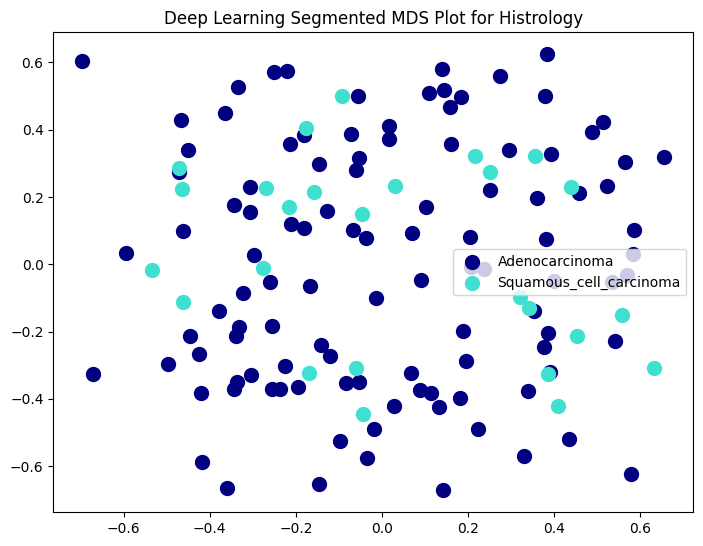

In [19]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import pandas as pd

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_MDS[Adenocarcinoma, 0], pos_MDS[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_MDS[Squamous_cell_carcinoma, 0], pos_MDS[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)
plt.title('Deep Learning Segmented MDS Plot for Histrology')

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

### PCA

/tmp/ipykernel_3899720/3224639602.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


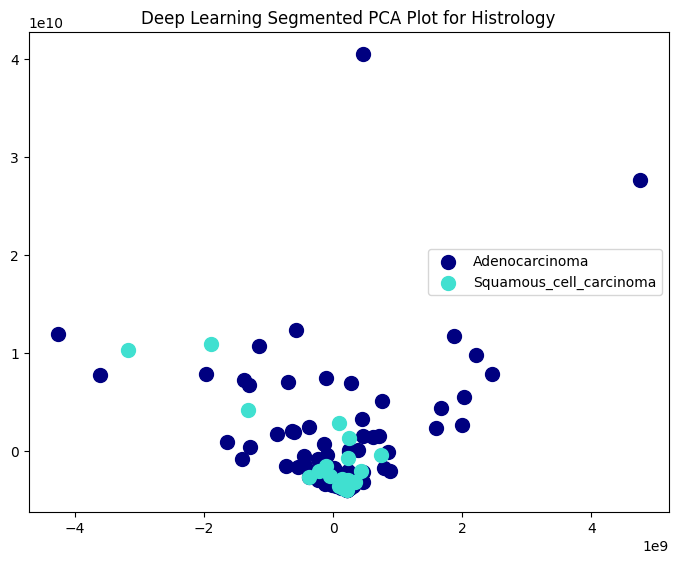

In [20]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
Adenocarcinoma = histrology[histrology['Histology']=="Adenocarcinoma"]['uid'].values
Squamous_cell_carcinoma= histrology[histrology['Histology']=="Squamous cell carcinoma"]['uid'].values

plt.scatter(pos_PCA[Adenocarcinoma, 0], pos_PCA[Adenocarcinoma, 1], color='navy', alpha=1.0, s=s, lw=1, label='Adenocarcinoma')
plt.scatter(pos_PCA[Squamous_cell_carcinoma, 0], pos_PCA[Squamous_cell_carcinoma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Squamous_cell_carcinoma')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)
plt.title('Deep Learning Segmented PCA Plot for Histrology')
similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

### With Type of Survial Status

### MDS

/tmp/ipykernel_3899720/2675875665.py:21: RuntimeWarning: divide by zero encountered in divide
  similarities = similarities.max() / similarities * 100


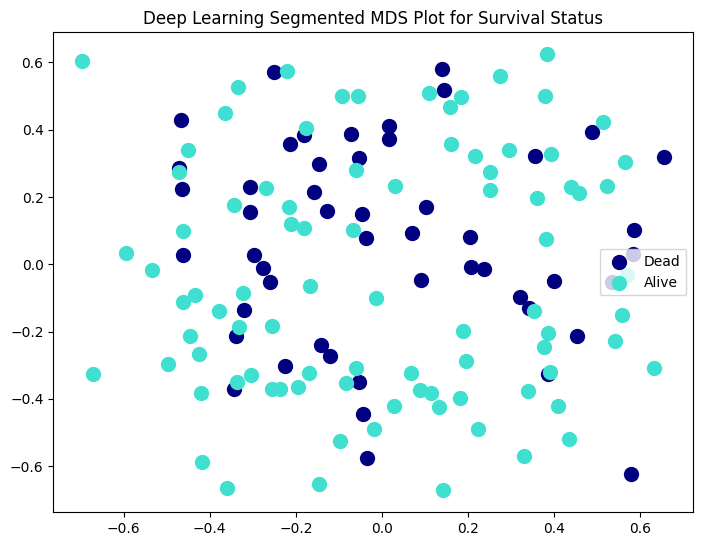

In [21]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_MDS[dead, 0], pos_MDS[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_MDS[alive, 0], pos_MDS[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)
plt.title('Deep Learning Segmented MDS Plot for Survival Status')
similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

### PCA

/tmp/ipykernel_3899720/3485419268.py:21: RuntimeWarning:

divide by zero encountered in divide



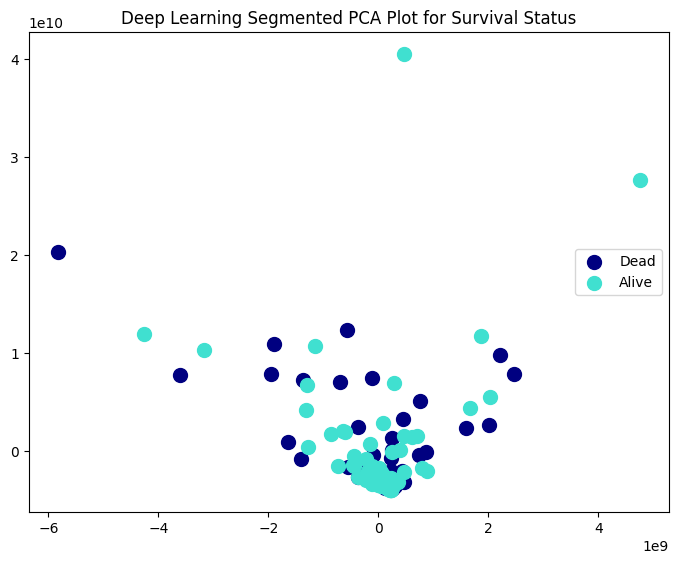

In [101]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# survival status
dead = survival_status[survival_status['labels']==1]['uid'].values
alive = survival_status[survival_status['labels']==0]['uid'].values

plt.scatter(pos_PCA[dead, 0], pos_PCA[dead, 1], color='navy', alpha=1.0, s=s, lw=1, label='Dead')
plt.scatter(pos_PCA[alive, 0], pos_PCA[alive, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='Alive')
# plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)
plt.title('Deep Learning Segmented PCA Plot for Survival Status')
similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

### Plot features as a heatmap

In [ ]:
# data_labels = pd.read_csv("/data4/hrehman/Clinical Data/NSCLCR01Radiogenomic_DATA_LABELS_2018-05-22_1500-shifted.csv")
# data_labels = data_labels['']
# types = np.array(csv['Histology'])

In [ ]:
# import pandas as pd
# import seaborn as sns

# # type of each tumor
# types =['meningioma', 'meningioma', 'meningioma', 'glioma', 'astrocytoma', 'glioma', 'astrocytoma', 'astrocytoma', 'astrocytoma', 'glioma']
# types = 

# # Construct a pandas dataframe from the samples
# d = pd.DataFrame(data=samples, columns=feature_names, index=types)

# corr = d.corr()

# # Set up the matplotlib figure, make it big!
# f, ax = plt.subplots(figsize=(15, 10))

# # Draw the heatmap using seaborn
# sns.heatmap(corr, vmax=.8, square=True)

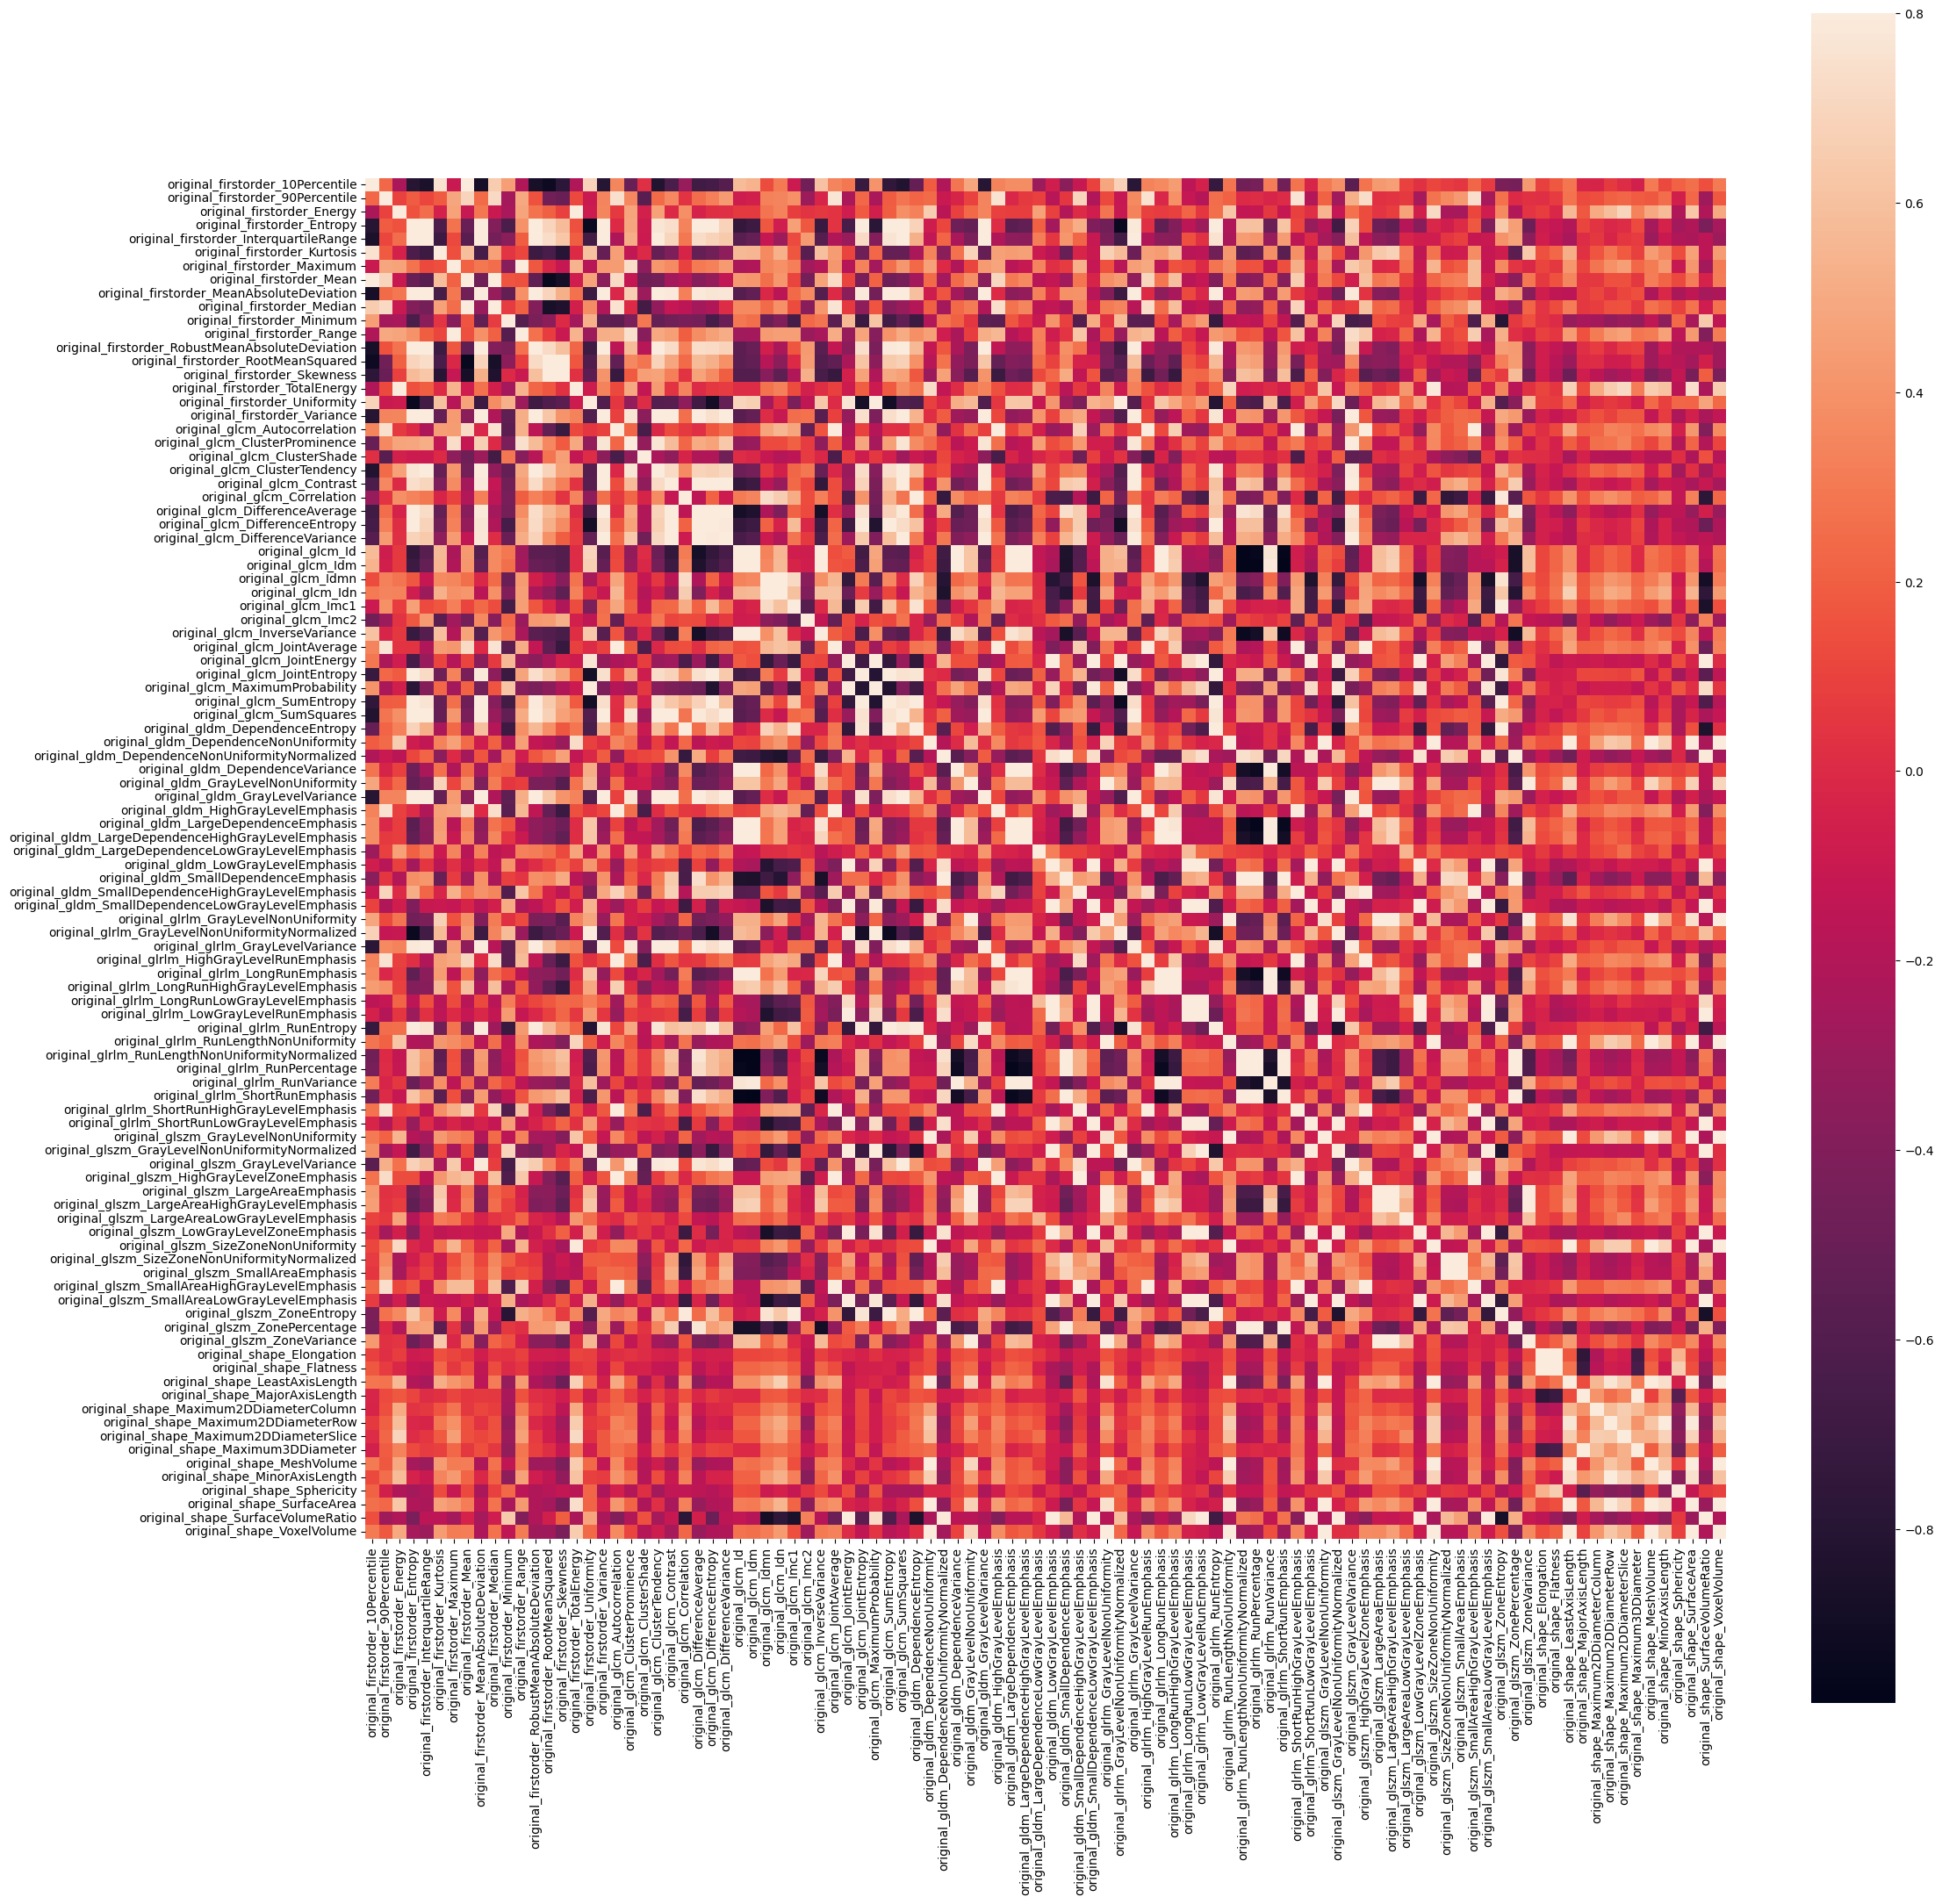

In [10]:
# Construct a pandas dataframe from the samples
d = pandas.DataFrame(data=samples, columns=feature_names)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(25,25))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

#### Cluster the heatmap

/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/hrehman/radiomics_venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


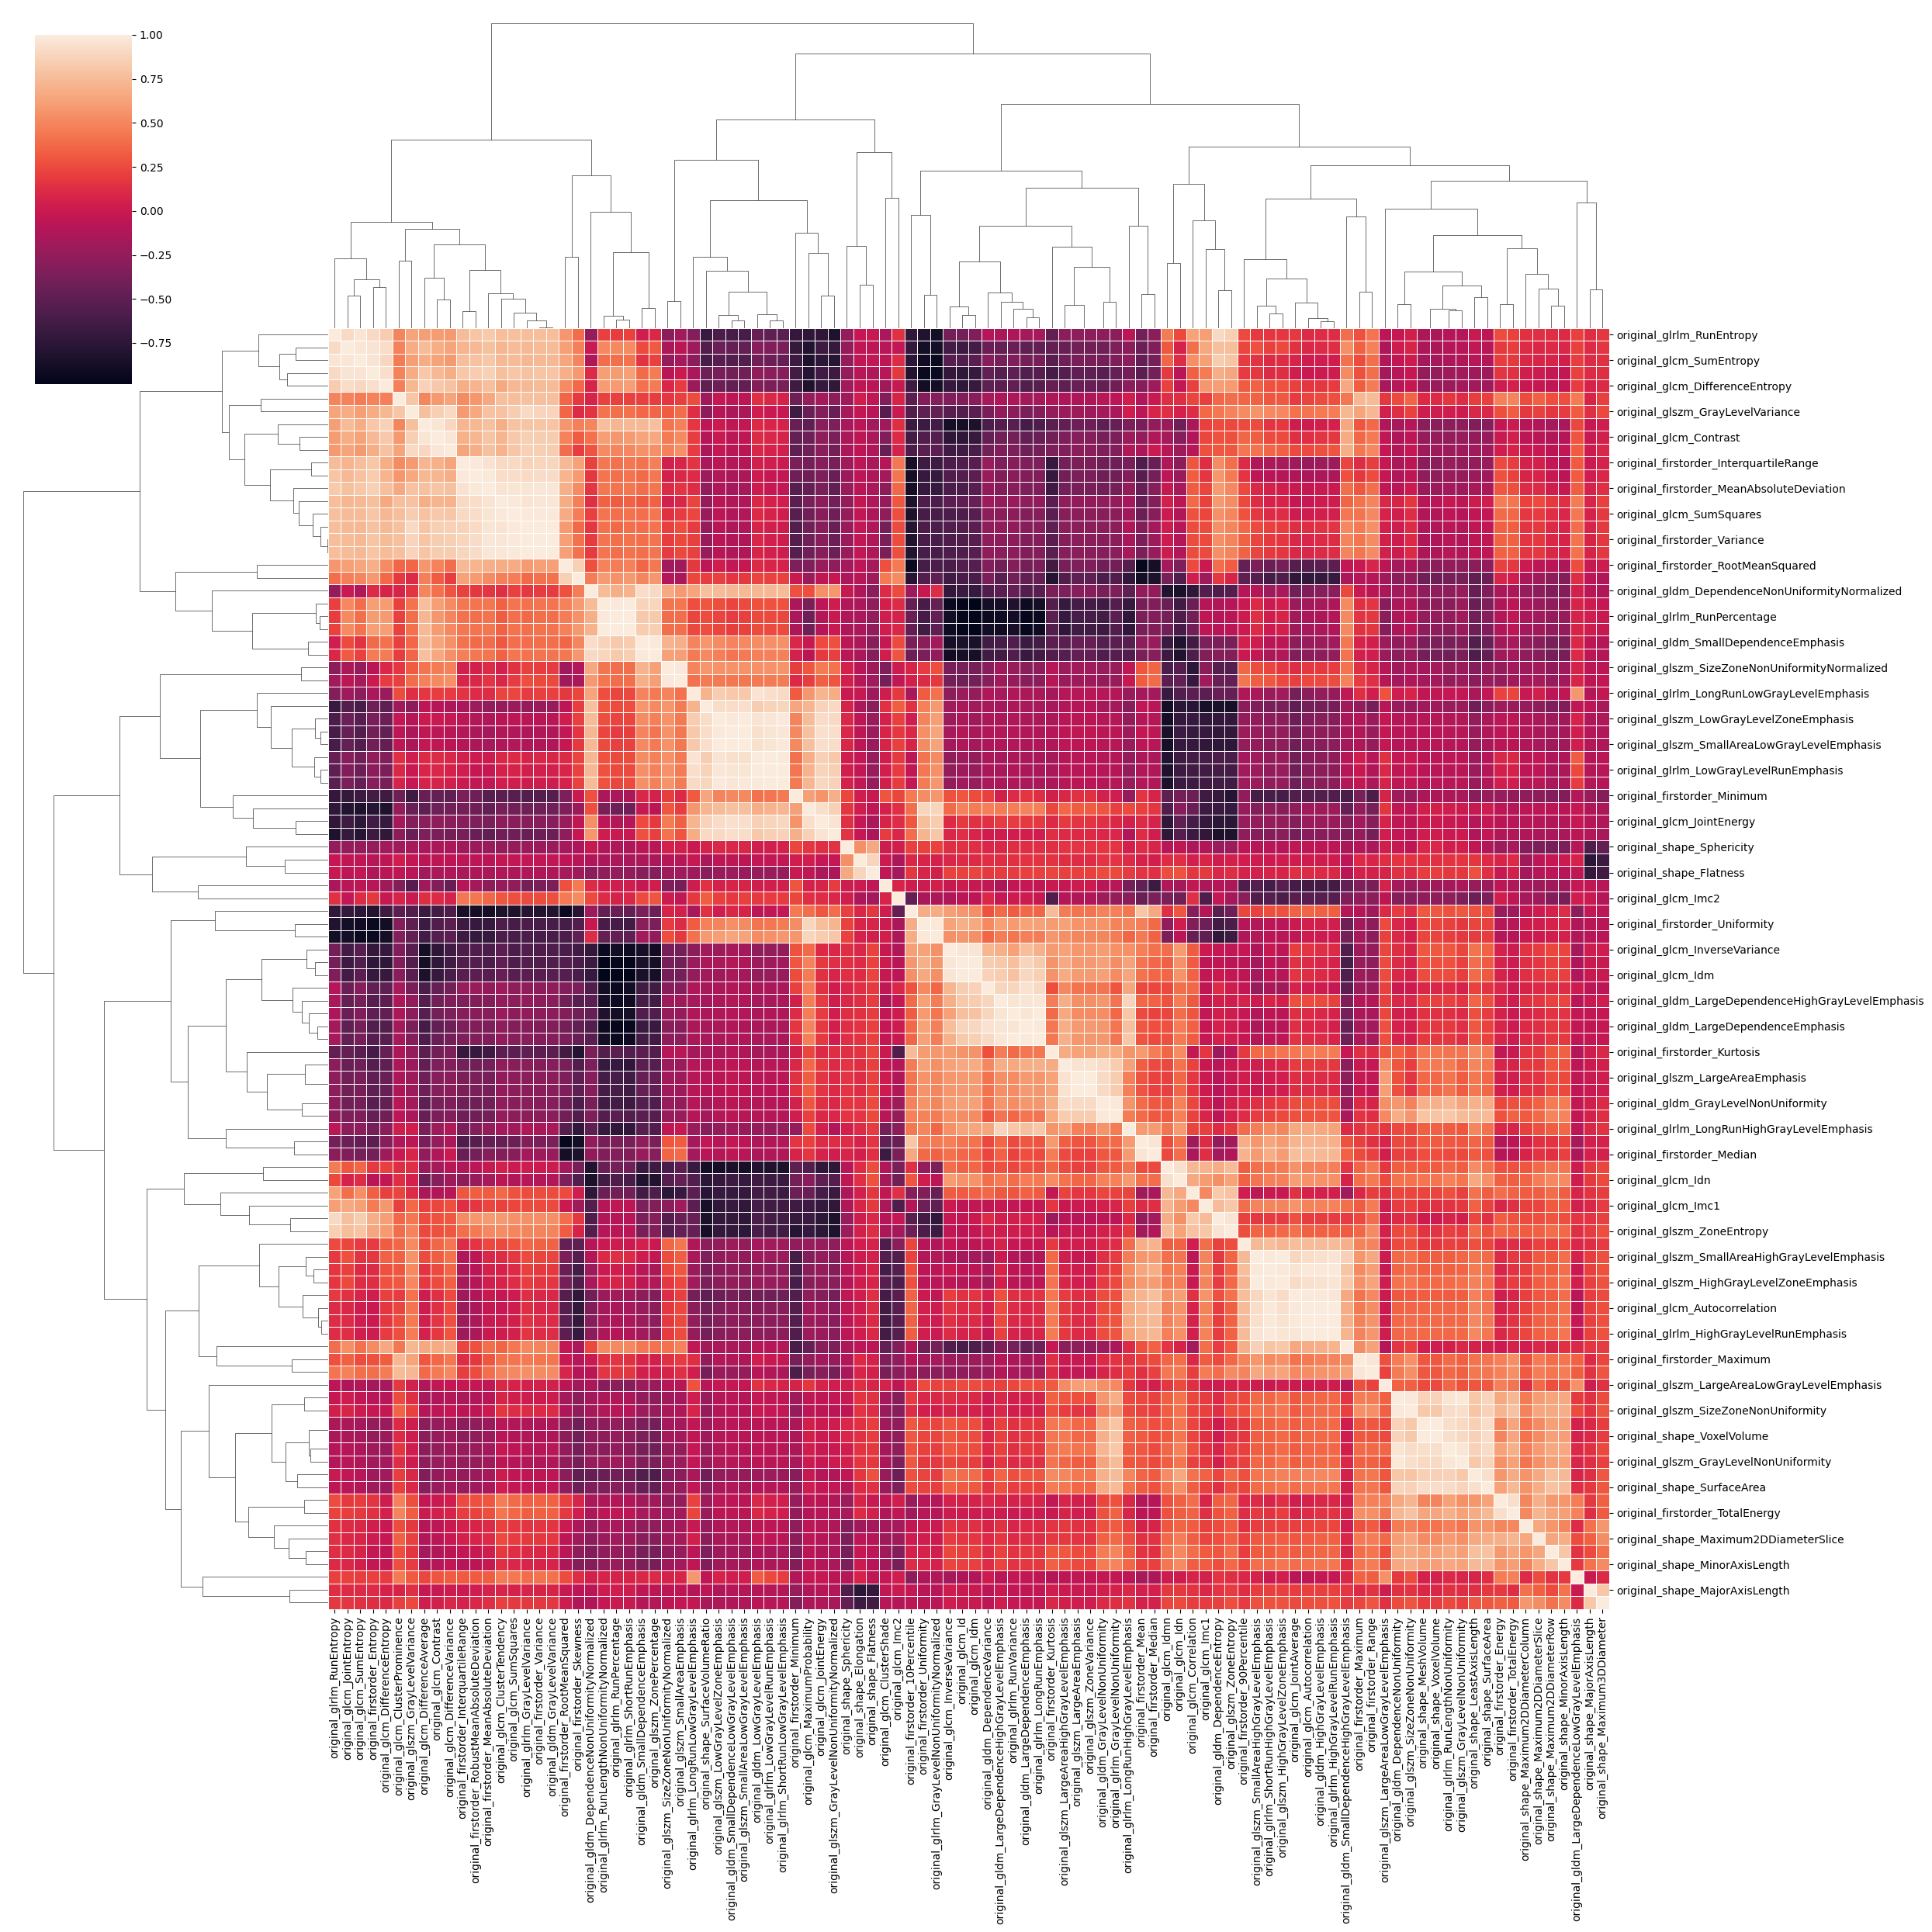

In [11]:
# Choose a subset of features for clustering
dd = d.iloc[:,:]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(25,25))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

### PCP

In [19]:
survival_status

Survival Status  Case ID  uid  labels
49            Alive  R01-001    0       0
50            Alive  R01-002    1       0
51            Alive  R01-003    2       0
52            Alive  R01-004    3       0
53             Dead  R01-005    4       1
..              ...      ...  ...     ...
189           Alive  R01-141  132       0
190           Alive  R01-142  133       0
192           Alive  R01-144  134       0
193           Alive  R01-145  135       0
194            Dead  R01-146  136       1

[137 rows x 4 columns]

In [20]:
d['uid'] = np.arange(len(config_patinets))
d['survival_status'] = list(survival_status['labels'])
d.columns[10:50]

Index(['original_firstorder_Minimum', 'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_firstorder_RootMeanSquared', 'original_firstorder_Skewness',
       'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity',
       'original_firstorder_Variance', 'original_glcm_Autocorrelation',
       'original_glcm_ClusterProminence', 'original_glcm_ClusterShade',
       'original_glcm_ClusterTendency', 'original_glcm_Contrast',
       'original_glcm_Correlation', 'original_glcm_DifferenceAverage',
       'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance',
       'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idmn',
       'original_glcm_Idn', 'original_glcm_Imc1', 'original_glcm_Imc2',
       'original_glcm_InverseVariance', 'original_glcm_JointAverage',
       'original_glcm_JointEnergy', 'original_glcm_JointEntropy',
       'original_glcm_MaximumProbability', 'original_glcm_SumEntropy',
       'origi

In [21]:
import numpy as np
count = 0
samples_full_data = np.zeros((len(config_patinets)+1,len(feature_names)+1))
for patient in patients:
    if str(patient+'.txt') in config_patinets:
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, features[patient][feature_name])
        a = np.append(a,int(patient.strip('-')[-1]))
        samples_full_data[count,:] = a
        count +=1
# May have NaNs
samples_full_data = np.nan_to_num(samples_full_data)

In [22]:
survival_status

Survival Status  Case ID  uid  labels
49            Alive  R01-001    0       0
50            Alive  R01-002    1       0
51            Alive  R01-003    2       0
52            Alive  R01-004    3       0
53             Dead  R01-005    4       1
..              ...      ...  ...     ...
189           Alive  R01-141  132       0
190           Alive  R01-142  133       0
192           Alive  R01-144  134       0
193           Alive  R01-145  135       0
194            Dead  R01-146  136       1

[137 rows x 4 columns]

In [23]:
survival_status['Case ID']

49     R01-001
50     R01-002
51     R01-003
52     R01-004
53     R01-005
        ...   
189    R01-141
190    R01-142
192    R01-144
193    R01-145
194    R01-146
Name: Case ID, Length: 137, dtype: object

In [24]:
all_features = feature_names + ['remove']
data = pandas.DataFrame(data=samples_full_data, columns=all_features)
data = data.iloc[:-1 , :]
data = data.iloc[:, :-1]
data['labels'] = survival_status['labels'].values
data['Patient_id'] = survival_status['Case ID'].values
data['survival_status'] = survival_status['Survival Status'].values

In [105]:

# correlated
import plotly.express as px
df = data
fig = px.parallel_coordinates(df,
                              dimensions=['labels','original_glrlm_RunEntropy', 'original_glcm_JointEnergy', 'original_glcm_SumEntropy',
                                          'original_firstorder_Entropy'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=3)
fig.show()

In [104]:
# shape
import plotly.express as px
df = data
fig = px.parallel_coordinates(df,
                              dimensions=['labels','original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume',
                                          'original_shape_SurfaceVolumeRatio'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=3)
fig.show()

In [108]:
# uncorrelated
import plotly.express as px
df = data
fig = px.parallel_coordinates(df,
                              dimensions=['labels','original_shape_SurfaceVolumeRatio', 'original_gldm_SmallDependenceLowGrayLevelEmphasis', 'original_glszm_SmallAreaLowGrayLevelEmphasis',
                                          'original_glszm_SmallAreaEmphasis'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=1)
fig.show()

In [37]:
import plotly.express as px
df = data
fig = px.parallel_coordinates(df,
                              dimensions=['labels','original_glcm_InverseVariance', 'original_glcm_JointAverage',
       'original_glcm_JointEnergy', 'original_glcm_JointEntropy',
       'original_glcm_MaximumProbability', 'original_glcm_SumEntropy',
       'original_glcm_SumSquares', 'original_gldm_DependenceEntropy'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

Show the distribution of different variables

In [41]:
# make a cleaner vefirst_colson
clean_df = df[feature_names].copy()
# clean_df.columns = [
#     ' '.join(c_col.split('original_')[-1].split('_')) 
#     for c_col in feature_names
# ]
clean_col_names = clean_df.columns[len(feature_names):]
# fix some of the artifacts from the radiomics tool
obj_cols = clean_df[clean_col_names].select_dtypes(['object']).columns.tolist()
for c_col in obj_cols:
    clean_df[c_col] = clean_df[c_col].map(lambda x: float(x))
clean_df.to_csv('clean_radiomics_table.csv', index=False)
clean_df.sample(3)

original_firstorder_10Percentile  original_firstorder_90Percentile   
90                             -712.0                             121.0  \
19                             -721.0                            -103.1   
117                            -885.0                               2.7   

     original_firstorder_Energy  original_firstorder_Entropy   
90                 3.585907e+08                     5.308360  \
19                 3.837911e+09                     5.043052   
117                3.321093e+09                     5.415911   

     original_firstorder_InterquartileRange  original_firstorder_Kurtosis   
90                                   468.00                      2.627917  \
19                                   322.75                      2.507447   
117                                  613.00                      1.764345   

     original_firstorder_Maximum  original_firstorder_Mean   
90                         586.0               -186.465985  \
19                         150.0               -466.316272   
117                        283.0               -497.221850   

     original_firstorder_MeanAbsoluteDeviation  original_firstorder_Median   
90                                  274.787201                       -41.0  \
19                                  186.784017                      -518.0   
117                                 292.987794                      -582.0   

     ...  original_shape_Maximum2DDiameterColumn   
90   ...                               20.920195  \
19   ...                               37.732728   
117  ...                               33.854367   

     original_shape_Maximum2DDiameterRow   
90                             21.974709  \
19                             32.561544   
117                            36.590868   

     original_shape_Maximum2DDiameterSlice  original_shape_Maximum3DDiameter   
90                               22.159740                         23.945050  \
19                               39.977105                         40.882555   
117                              34.106999                         38.710918   

     original_shape_MeshVolume  original_shape_MinorAxisLength   
90                 2839.751190                       16.821827  \
19                10517.186228                       25.996808   
117                5691.089630                       28.907943   

     original_shape_Sphericity  original_shape_SurfaceArea   
90                    0.794088                 1221.244255  \
19                    0.713733                 3252.480010   
117                   0.557120                 2766.935096   

     original_shape_SurfaceVolumeRatio  original_shape_VoxelVolume  
90                            0.430053                 2864.106797  
19                            0.309254                10547.619629  
117                           0.486187                 5718.795776  

[3 rows x 100 columns]

### Distributions

In [42]:
clean_df

original_firstorder_10Percentile  original_firstorder_90Percentile   
0                              -413.4                              41.4  \
1                              -490.2                              35.2   
2                              -696.0                              91.0   
3                              -468.0                             148.0   
4                              -185.0                              51.0   
..                                ...                               ...   
132                            -677.0                             125.4   
133                            -595.0                             112.0   
134                            -753.0                              73.0   
135                            -711.0                             121.7   
136                            -299.0                             113.0   

     original_firstorder_Energy  original_firstorder_Entropy   
0                  1.300704e+08                     4.410179  \
1                  1.509474e+08                     4.437764   
2                  3.482473e+08                     5.154500   
3                  9.123855e+07                     4.813751   
4                  2.327635e+08                     3.444492   
..                          ...                          ...   
132                7.464833e+08                     5.416443   
133                1.868675e+09                     5.324092   
134                7.670512e+08                     5.473738   
135                7.850675e+09                     5.202658   
136                6.557951e+09                     3.992784   

     original_firstorder_InterquartileRange  original_firstorder_Kurtosis   
0                                     266.0                      2.699818  \
1                                     272.0                      3.250647   
2                                     483.5                      2.249295   
3                                     245.5                      3.935420   
4                                      63.0                      8.834677   
..                                      ...                           ...   
132                                   459.5                      2.674535   
133                                   408.0                      2.419308   
134                                   580.0                      1.877307   
135                                   500.0                      2.396296   
136                                   127.0                      6.381430   

     original_firstorder_Maximum  original_firstorder_Mean   
0                          154.0               -128.563454  \
1                          144.0               -143.467708   
2                          376.0               -205.738462   
3                          366.0                -66.283355   
4                          391.0                -30.961731   
..                           ...                       ...   
132                        525.0               -197.171575   
133                        467.0               -190.140906   
134                        602.0               -291.449901   
135                       1288.0               -179.829745   
136                        991.0                -15.268467   

     original_firstorder_MeanAbsoluteDeviation  original_firstorder_Median   
0                                   151.411842                       -52.0  \
1                                   171.835955                       -43.0   
2                                   263.471680                       -70.0   
3                                   184.393689                        20.5   
4                                    75.040214                         5.0   
..                                         ...                         ...   
132                                 261.596433                       -93.0   
133                                 225.1

In [43]:
clean_df.to_csv('/data4/hrehman/Clinical_Data/distribution_data_DL.csv')

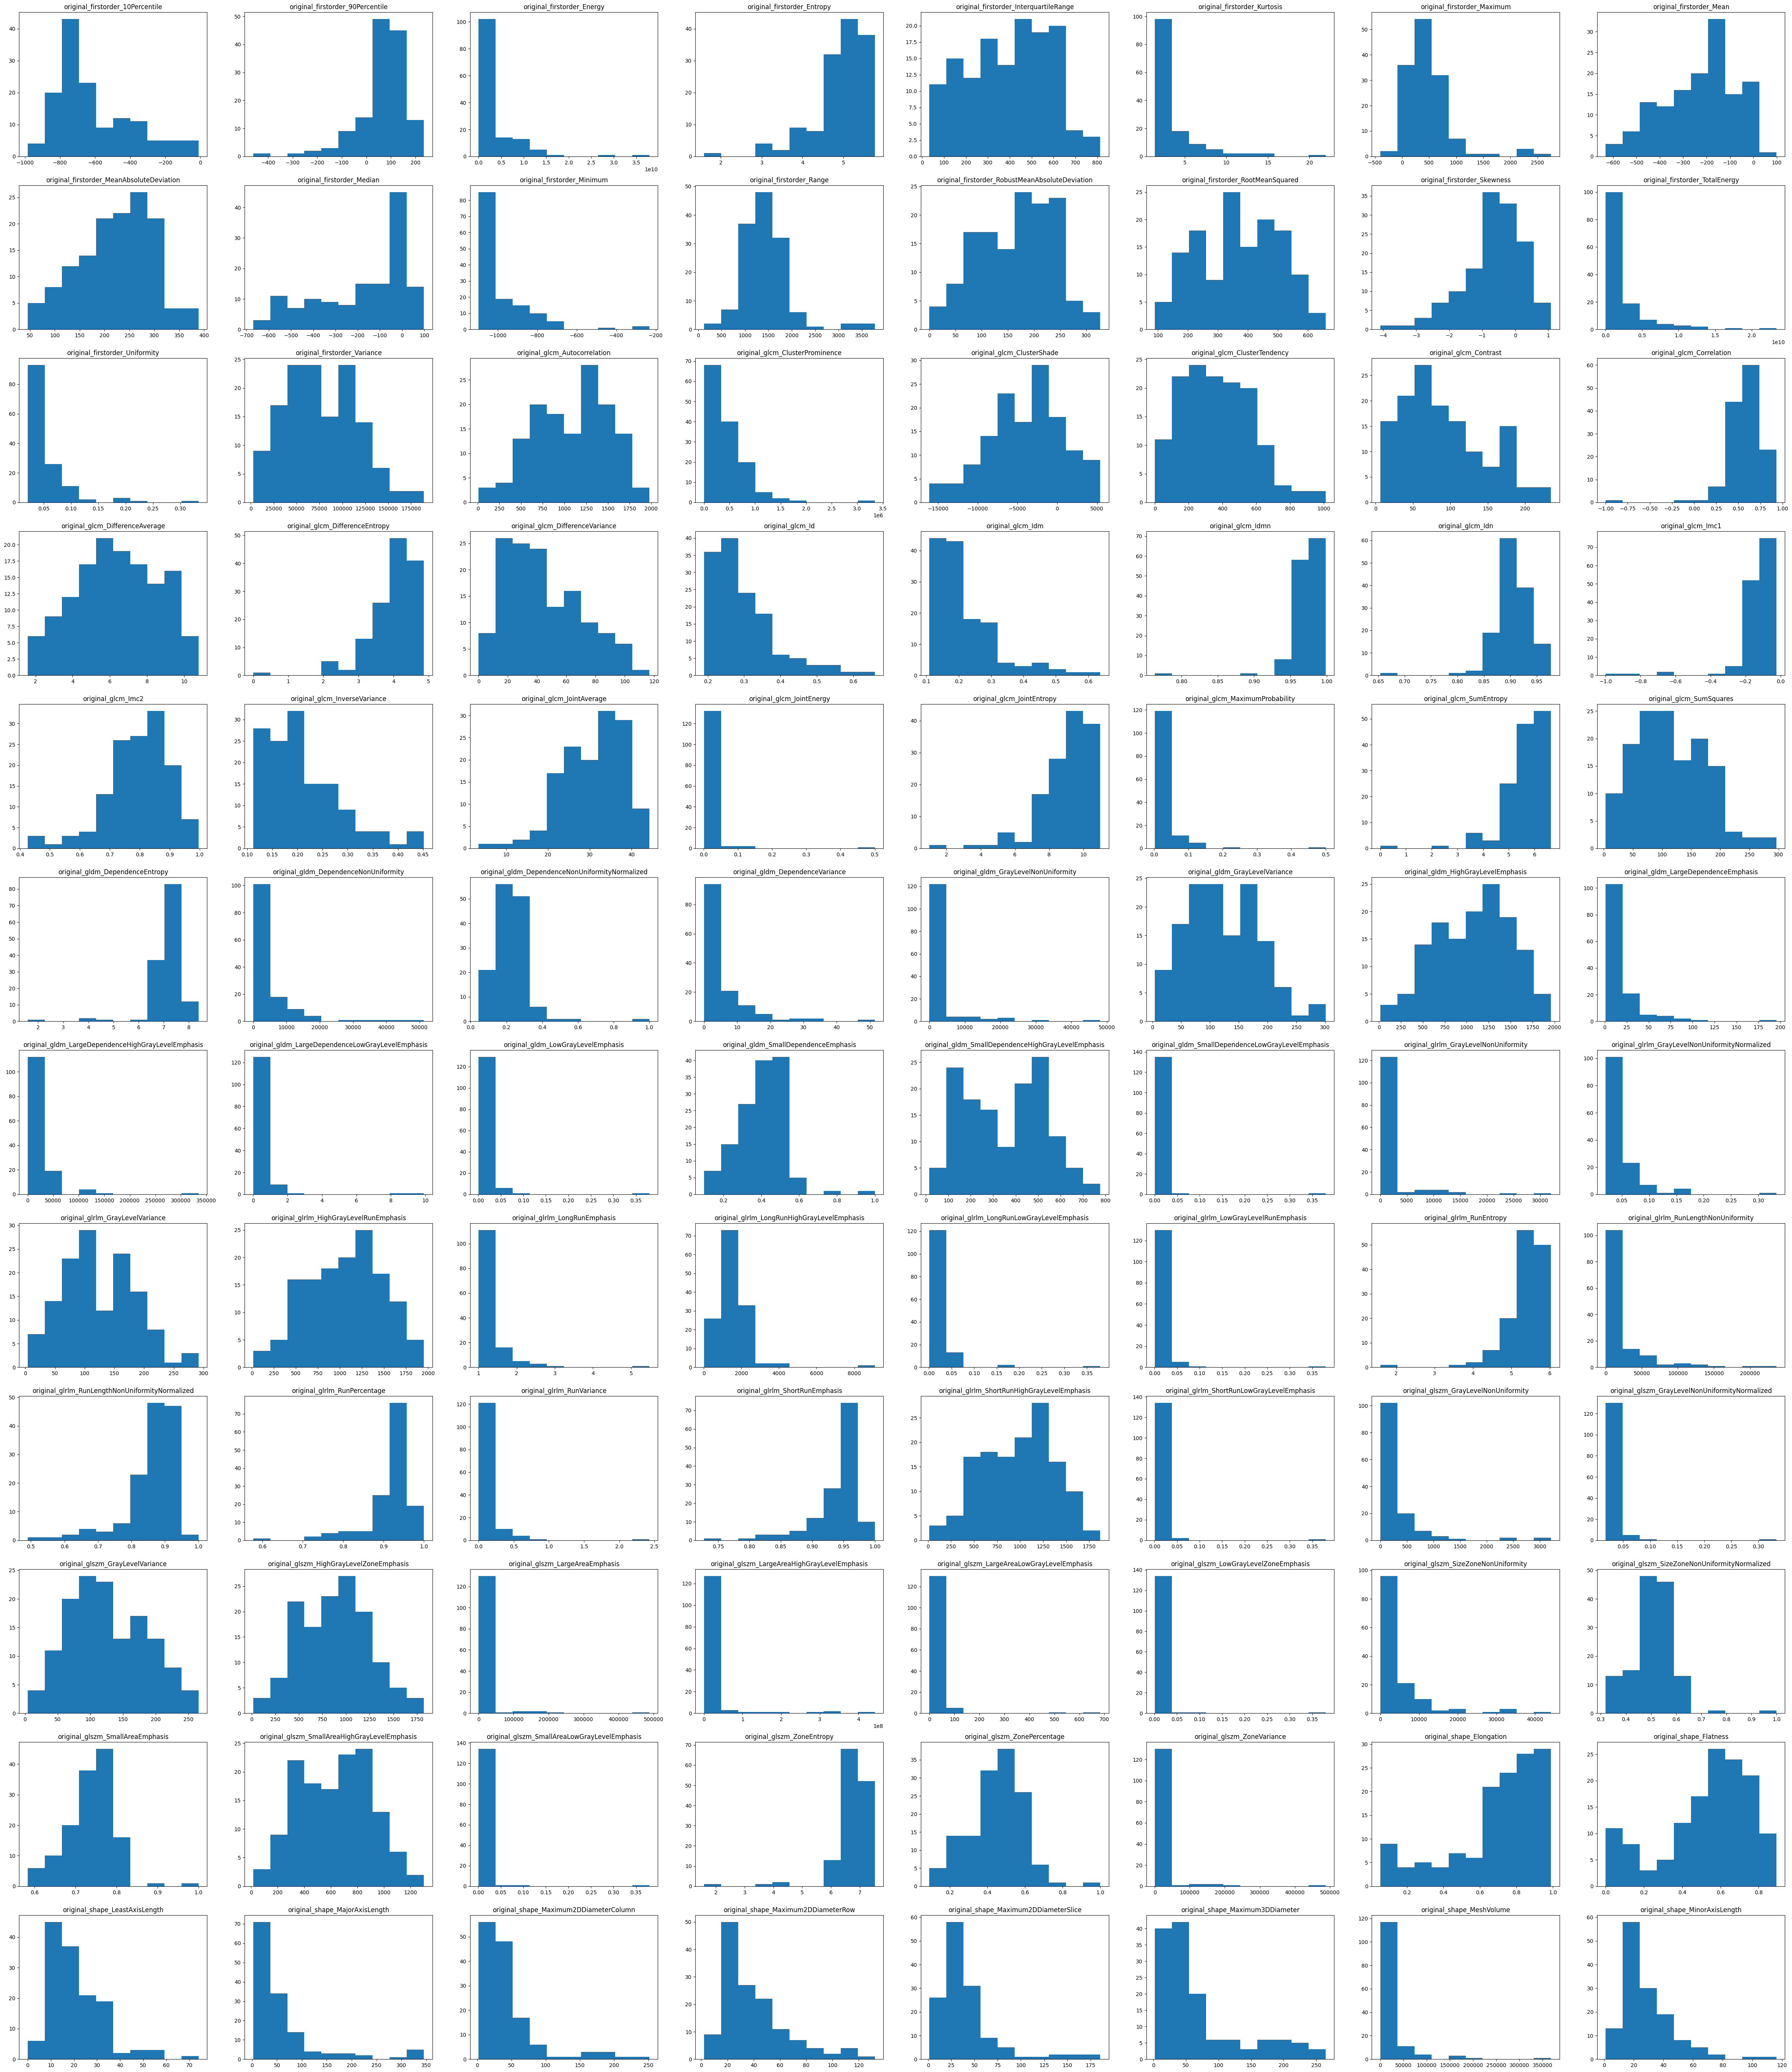

In [46]:
fig, m_axs = plt.subplots(12, 8, figsize=(60, 70))
for c_ax, c_var in zip(m_axs.flatten(), feature_names):
    c_ax.hist(clean_df[c_var].values, bins=10)
    c_ax.set_title('\n'.join(c_var.split(' ')))
fig.savefig('all_metrics.png')

# Modeling

#### RF

In [25]:
from sklearn.model_selection import RepeatedStratifiedKFold
import builtins
dict = builtins.dict
def RF_CV(X_std,y):
	RF_xy_trainlist = []
	RF_xy_testlist = []
	# dataset
	X, y = X_std, y
	# configure the cross-validation procedure
	cv_outer = KFold(n_splits=3, shuffle=True, random_state=1)
        
	# enumerate splits
	outer_results = list()
	i = 0
	sgkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
	for train_ix, test_ix in sgkf.split(X,y):
		# split data
		# X_train, X_test = X[train_ix, :], X[test_ix, :]
		# y_train, y_test = y[train_ix], y[test_ix]
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		RF_xy_trainlist.append([X_train,y_train ])
		RF_xy_testlist.append([X_test, y_test])

		# configure the cross-validation procedure
		cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
		# define the model
		model = RandomForestClassifier(random_state=1)
			# define search space
		space = dict()
		# space["max_features"] = ['sqrt', 'log2']
		space['n_estimators'] = [10, 100, 500]
		space['min_samples_leaf'] = [5,10,15]
		space['criterion'] = ["gini","entropy"]
		# space['max_features'] = [10,15,20]
			
			# define search
		search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
		# execute search
		result = search.fit(X_train, y_train)
		# get the best performing model fit on the whole training set
		best_model = result.best_estimator_
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		# evaluate the model
		acc = accuracy_score(y_test, yhat)
		# store the result
		outer_results.append(acc)
		# report progress
		print(i,'>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
		i+=1
	# summarize the estimated performance of the model
	print('Accuracy: %.3f (%.3f)' % (statistics.mean(outer_results), statistics.stdev(outer_results)))
	return RF_xy_testlist,RF_xy_trainlist


def RandomForest_ROC(X_std, y ,criterion,n_estimators,min_samples_leaf):
        forest = RandomForestClassifier(bootstrap=True,criterion=criterion,oob_score=True,n_jobs=-1,n_estimators=n_estimators,min_samples_leaf=min_samples_leaf,random_state=1,class_weight='balanced')
        cv = StratifiedKFold(n_splits=10)
        classifier = forest
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        i = 0
        for train, test in cv.split(X_std, y):
            probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
            i += 1
        return tprs,aucs,mean_fpr,forest

#### SVM

In [26]:

def SVM_CV(X_std, y):
		# dataset
		X, y = X_std, y
		xy_trainlist = []
		xy_testlist = []
		# configure the cross-validation procedure
		cv_outer = KFold(n_splits=20, shuffle=True, random_state=1)
		# enumerate splits
		outer_results = list()
		i = 0
		sgkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
		for train_ix, test_ix in sgkf.split(X,y):
			# split data
			# X_train, X_test = X[train_ix, :], X[test_ix, :]
			# y_train, y_test = y[train_ix], y[test_ix]
			X_train, X_test = X[train_ix], X[test_ix]
			y_train, y_test = y[train_ix], y[test_ix]
			xy_trainlist.append([X_train,y_train ])
			xy_testlist.append([X_test, y_test])
			# configure the cross-validation procedure
			cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
			# define the model
			model = SVC(random_state=1)
			# define search space
			space = dict()
			space['kernel'] = ["poly", "rbf", "sigmoid"]
			# space['gamma'] = ["scale","auto"]
			space['C'] = [0.1,1.0,5]
			space["decision_function_shape"] = ['ovo','ovr']
			
			# define search
			search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True,return_train_score=True)
			# execute search
			result = search.fit(X_train, y_train)
			# get the best performing model fit on the whole training set
			best_model = result.best_estimator_
			# evaluate model on the hold out dataset
			yhat = best_model.predict(X_test)
			# evaluate the model
			acc = accuracy_score(y_test, yhat)
			# store the result
			outer_results.append(acc)
			# report progress
			print(i,'>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
			i+=1
		# summarize the estimated performance of the model
		print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))
		return xy_testlist , xy_trainlist
def SVM_ROC(X_std, y,C,kernel,decision_function_shape):
    svm = SVC(kernel=kernel, C=C,shrinking=False,probability=True,decision_function_shape=decision_function_shape,random_state=1)
    cv = StratifiedKFold(n_splits=10)
    classifier = svm
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X_std, y):
        probas_ = classifier.fit(X_std[train], y[train]).predict_proba(X_std[test])
        # clf.score(X_test, y_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    return tprs,aucs,mean_fpr,svm

#### without Feature Selection

In [28]:
def all_features():
        dataset_all_features = data.copy()
        class_mapping = {label: idx for idx, label in enumerate(np.unique(dataset_all_features['survival_status']))}
        class_mapping
        dataset_all_features['survival_status'] = dataset_all_features['survival_status'].map(class_mapping)
        y = LabelEncoder().fit_transform(dataset_all_features['survival_status'].values)
        X = dataset_all_features.iloc[:,0:len(dataset_all_features.columns)-3].values
        print(y.shape)
        print(X.shape)
        feat_labels = dataset_all_features.columns[0:len(dataset_all_features.columns)-3]
        return X,y,dataset_all_features

##### Random Forest

In [29]:
X,y,dataset_all_features  = all_features()
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print("X shape",X_std.shape)

(137,)
(137, 100)
X shape (137, 100)


In [ ]:
X,y,dataset_all_features  = all_features()
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print("X shape",X_std.shape)
RF_xy_testlist_1,RF_xy_trainlist_1 = RF_CV(X_std,y)

(137,)
(137, 100)
X shape (137, 100)


0 >acc=0.643, est=0.675, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}
1 >acc=0.643, est=0.658, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
2 >acc=0.714, est=0.634, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 10}
3 >acc=0.714, est=0.634, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
4 >acc=0.500, est=0.709, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
5 >acc=0.429, est=0.643, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 10}
6 >acc=0.500, est=0.649, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 500}
7 >acc=0.538, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 500}
8 >acc=0.615, est=0.614, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
9 >acc=0.615, est=0.646, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
10 >acc=0.857, est=0.601, cfg={'criterion': '

The optimal settings that we selected are 


11 >acc=0.857, est=0.646, cfg={'criterion': 'gini', 'min_samples_leaf': 20, 'n_estimators': 100}

In [30]:
rf_1_tprs,rf_1_aucs,rf_1_mean_fpr,forest = RandomForest_ROC(X_std,y,criterion='gini',n_estimators=500,min_samples_leaf=10)

/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: Depr

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and w

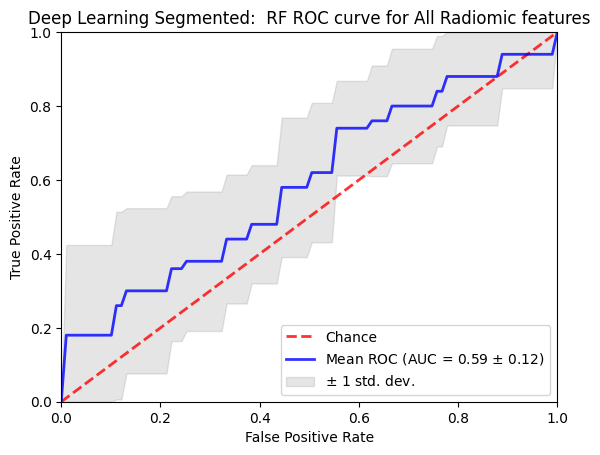

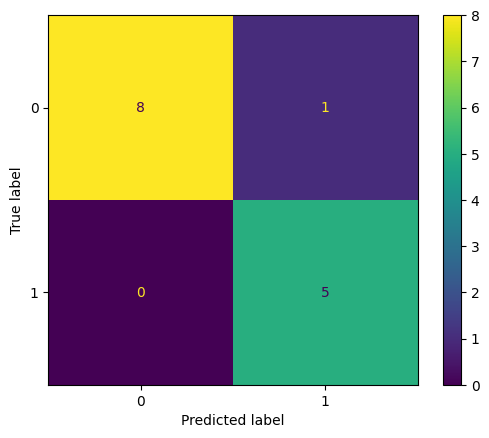

In [ ]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std,y,criterion='gini',n_estimators=500,min_samples_leaf=10)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented:  RF ROC curve for All Radiomic features')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist_1[10][0], RF_xy_testlist_1[10][1])

Text(0.5, 0, 'Permutation Importance')

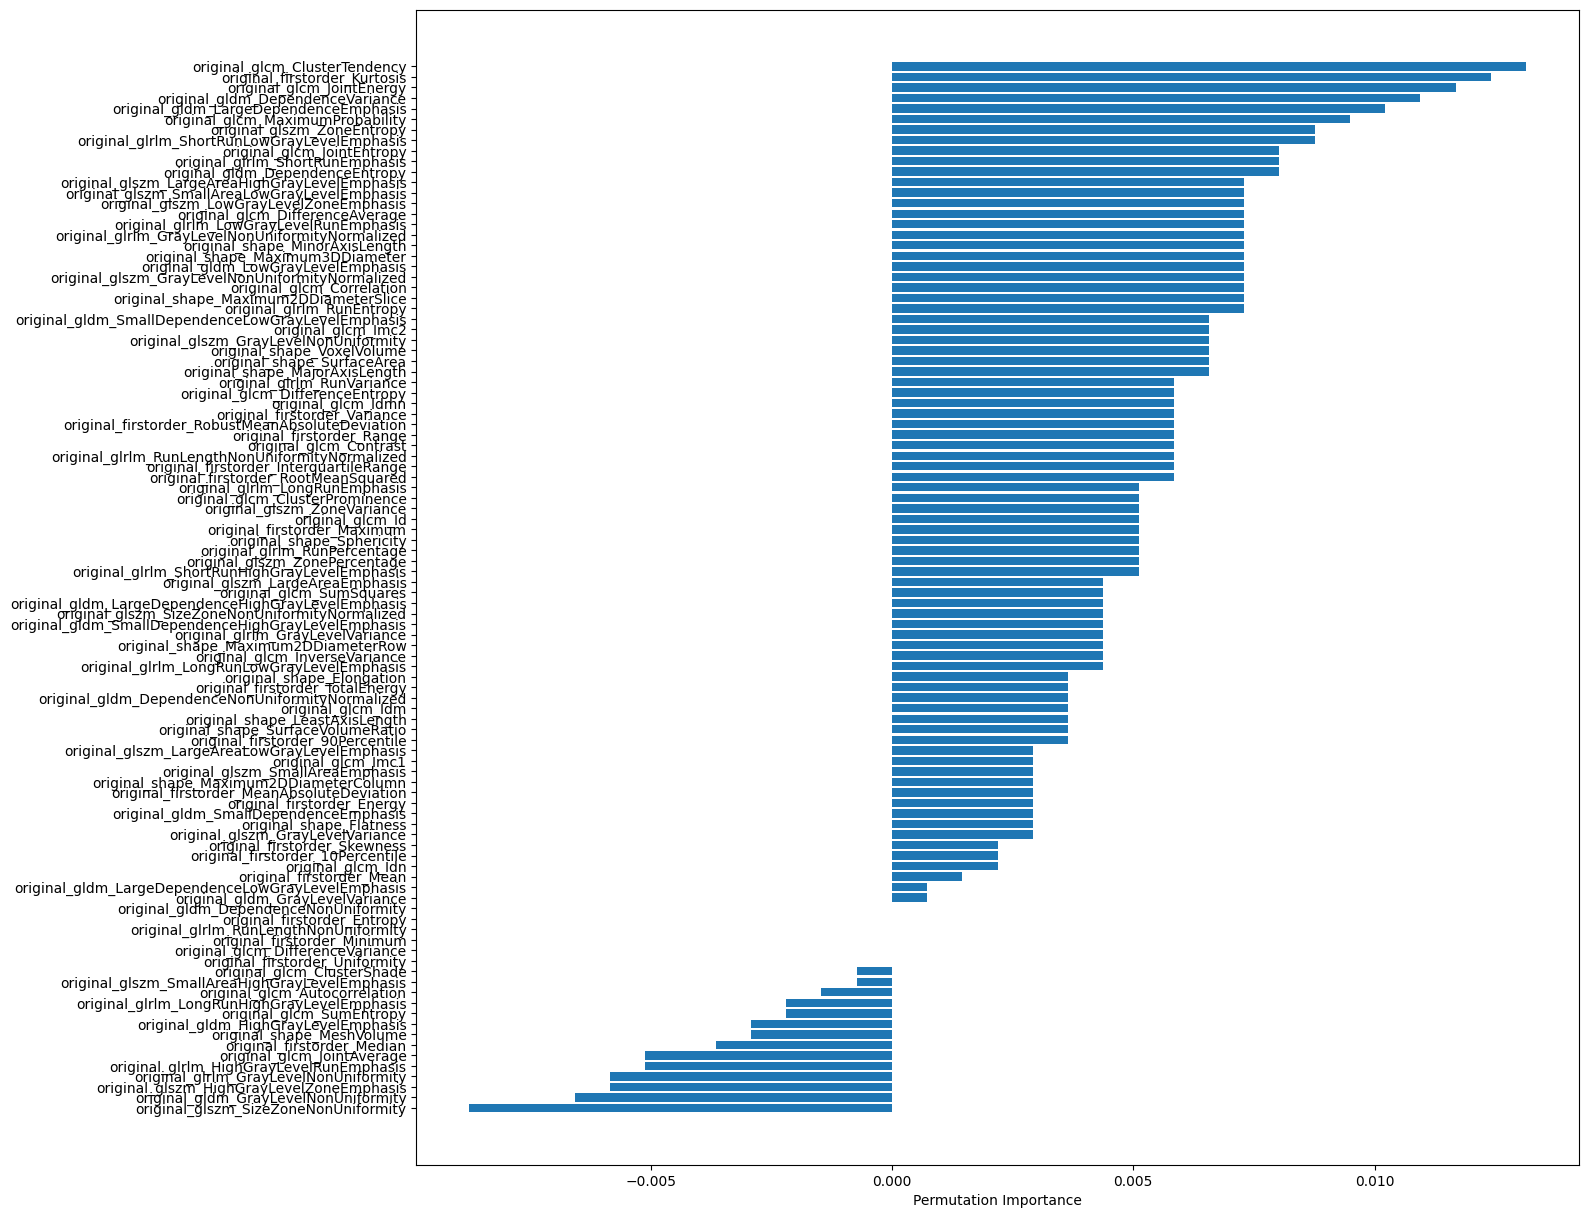

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(forest,X_std, y, n_repeats=10,random_state=0)

features  =np.array(list(dataset_all_features.columns[:-3])) 
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(15,15))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Permutation Importance')

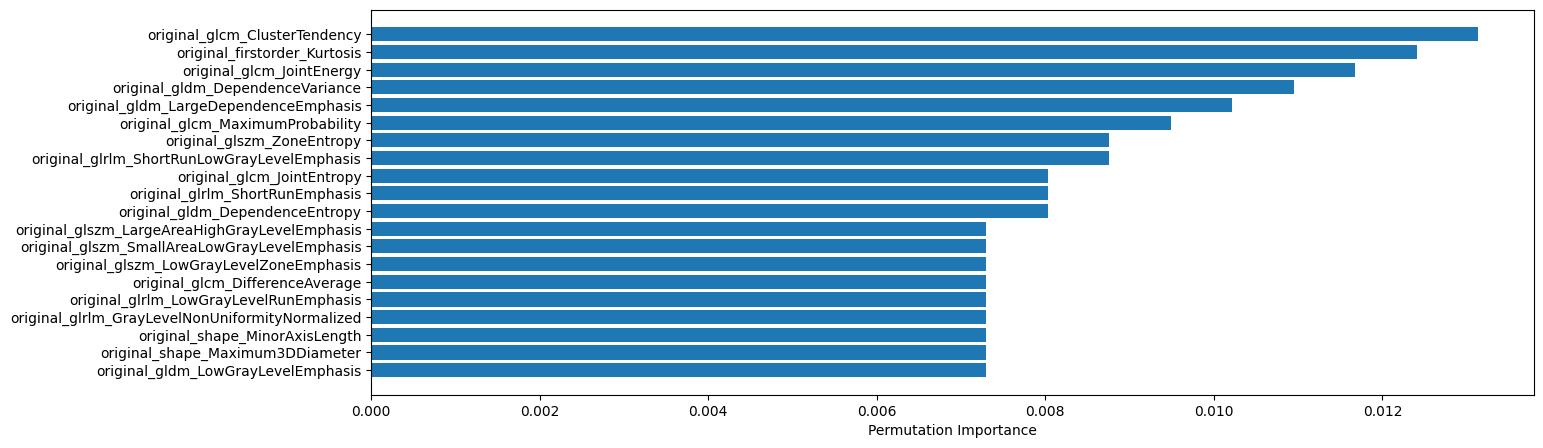

In [ ]:
plt.figure(figsize=(15,5))
plt.barh(features[sorted_idx[-20:]], result.importances_mean[sorted_idx[-20:]])
plt.xlabel("Permutation Importance")

##### SVM

In [31]:
X,y,dataset_all_features  = all_features()
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print("X shape",X_std.shape)

(137,)
(137, 100)
X shape (137, 100)


In [32]:
svm_1_tprs,svm_1_aucs,svm_1_mean_fpr,svm = SVM_ROC(X_std,y , C= 1, kernel = 'sigmoid' , decision_function_shape = 'ovo')

/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: Depr

In [ ]:
X,y,dataset_all_features  = all_features()
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
print("X shape",X_std.shape)
xy_testlist_1,xy_trainlist_1 = SVM_CV(X_std,y)

(137,)
(137, 100)
X shape (137, 100)
0 >acc=0.857, est=0.660, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
1 >acc=0.714, est=0.675, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
2 >acc=0.786, est=0.643, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
3 >acc=0.571, est=0.666, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
4 >acc=0.571, est=0.693, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
5 >acc=0.571, est=0.676, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
6 >acc=0.571, est=0.683, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
7 >acc=0.538, est=0.669, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
8 >acc=0.615, est=0.655, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
9 >acc=0.538, est=0.670, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
10 >acc=0.714, est=0.642, cfg={'C': 1.0, 'decision_fu

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and w

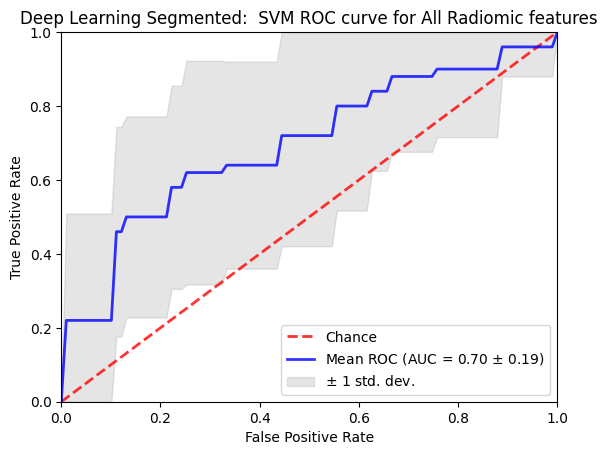

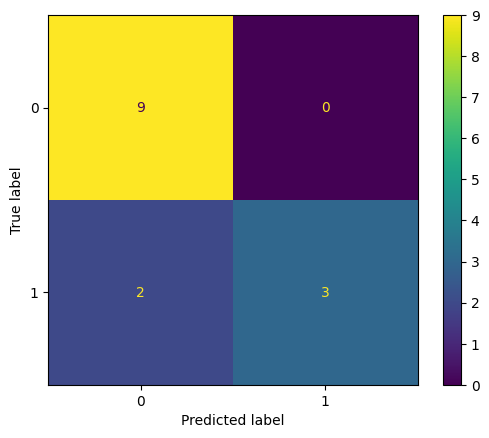

In [ ]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std,y , C= 1, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented:  SVM ROC curve for All Radiomic features')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist_1[10][0], xy_testlist_1[10][1])

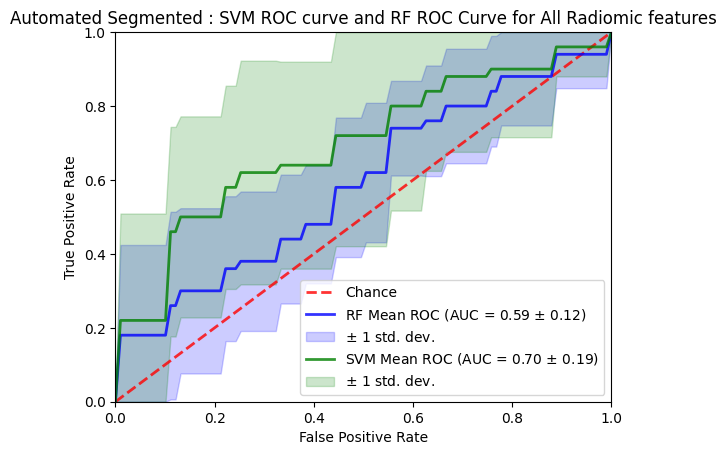

In [33]:
#set up plotting area
plt.figure(0).clf()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
rf_1_mean_tpr = np.mean(rf_1_tprs, axis=0)
rf_1_mean_tpr[-1] = 1.0
rf_1_mean_auc = auc(rf_1_mean_fpr, rf_1_mean_tpr)
rf_1_std_auc = np.std(rf_1_aucs)
plt.plot(rf_1_mean_fpr, rf_1_mean_tpr, color='b',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (rf_1_mean_auc, rf_1_std_auc),lw=2, alpha=.8)
rf_1_std_tpr = np.std(rf_1_tprs, axis=0)
rf_1_tprs_upper = np.minimum(rf_1_mean_tpr + rf_1_std_tpr, 1)
rf_1_tprs_lower = np.maximum(rf_1_mean_tpr - rf_1_std_tpr, 0)
plt.fill_between(rf_1_mean_fpr, rf_1_tprs_lower, rf_1_tprs_upper, color='b', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

svm_1_mean_tpr = np.mean(svm_1_tprs, axis=0)
svm_1_mean_tpr[-1] = 1.0
svm_1_mean_auc = auc(svm_1_mean_fpr, svm_1_mean_tpr)
svm_1_std_auc = np.std(svm_1_aucs)
plt.plot(svm_1_mean_fpr, svm_1_mean_tpr,color='g',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (svm_1_mean_auc, svm_1_std_auc),lw=2, alpha=.8)
svm_1_std_tpr = np.std(svm_1_tprs, axis=0)
svm_1_tprs_upper = np.minimum(svm_1_mean_tpr + svm_1_std_tpr, 1)
svm_1_tprs_lower = np.maximum(svm_1_mean_tpr - svm_1_std_tpr, 0)
plt.fill_between(svm_1_mean_fpr, svm_1_tprs_lower, svm_1_tprs_upper, color='g', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Automated Segmented : SVM ROC curve and RF ROC Curve for All Radiomic features')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
plt.show()

Text(0.5, 0, 'Permutation Importance')

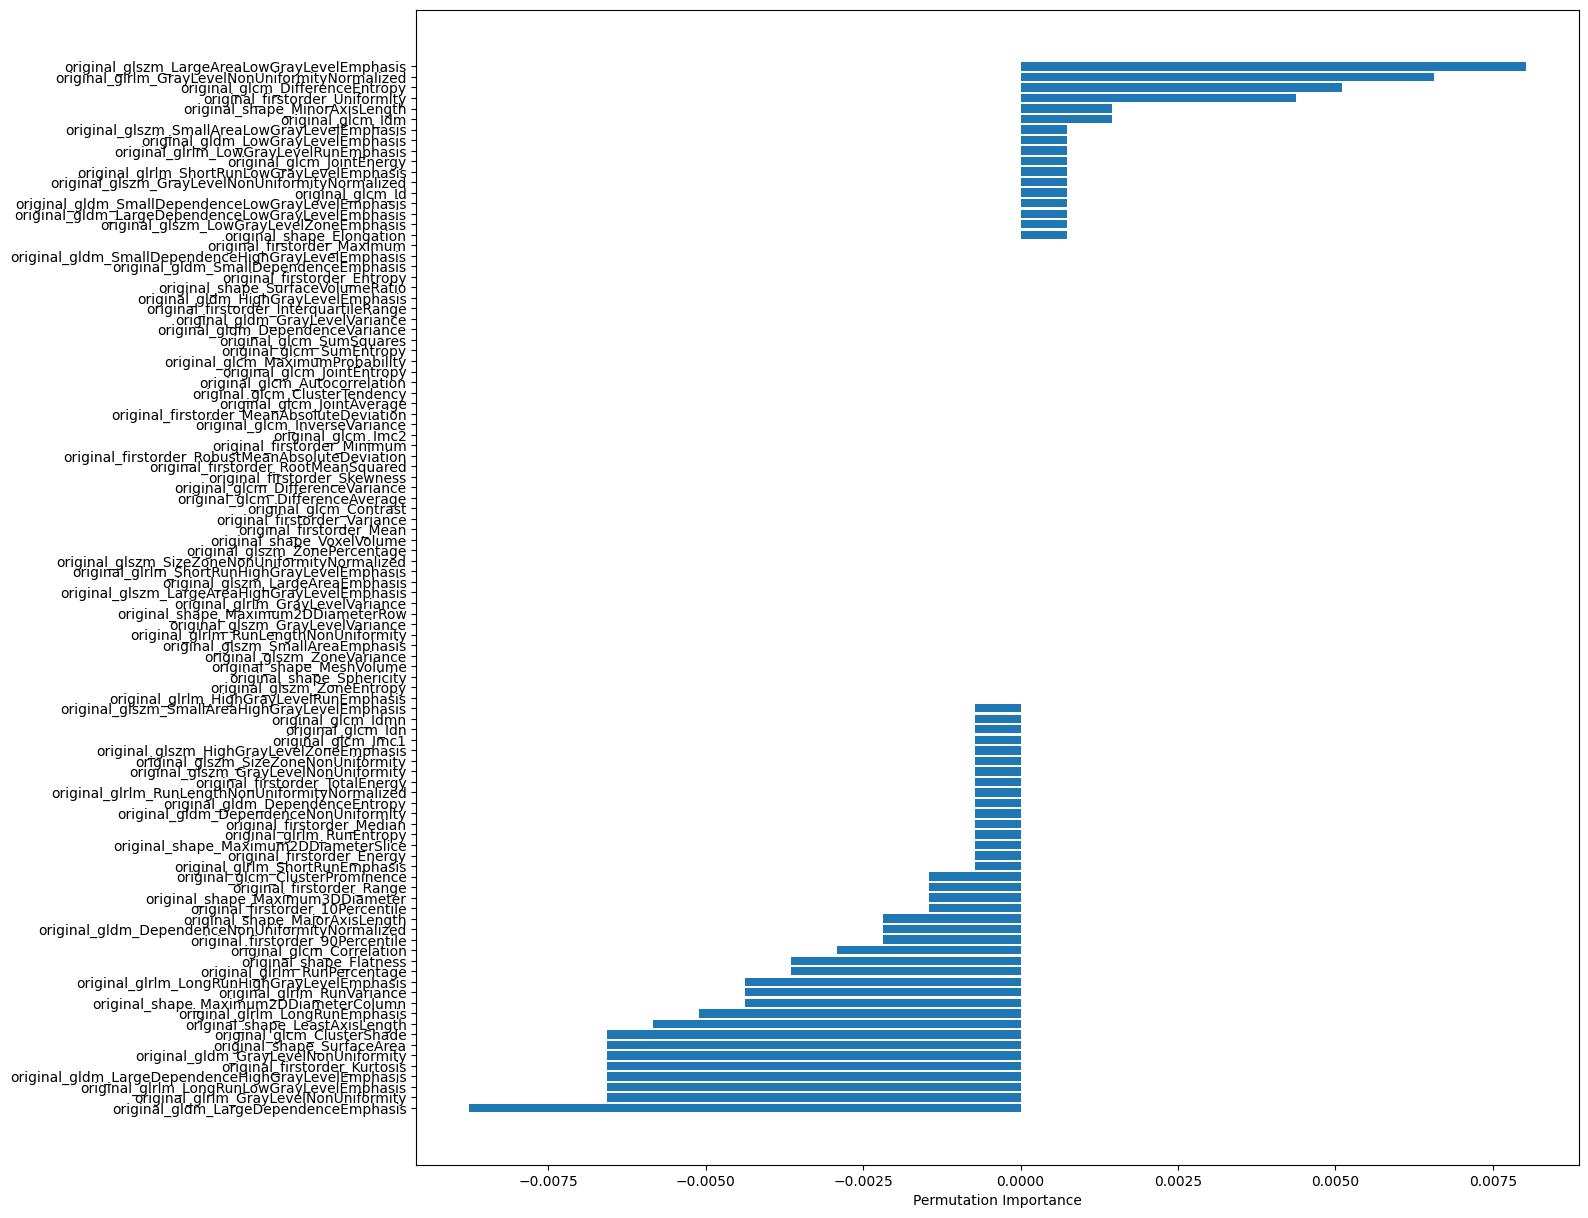

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(svm,X_std,y, n_repeats=10,random_state=0)
feat  = list(dataset_all_features.columns[:-3])
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(15,15))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Permutation Importance')

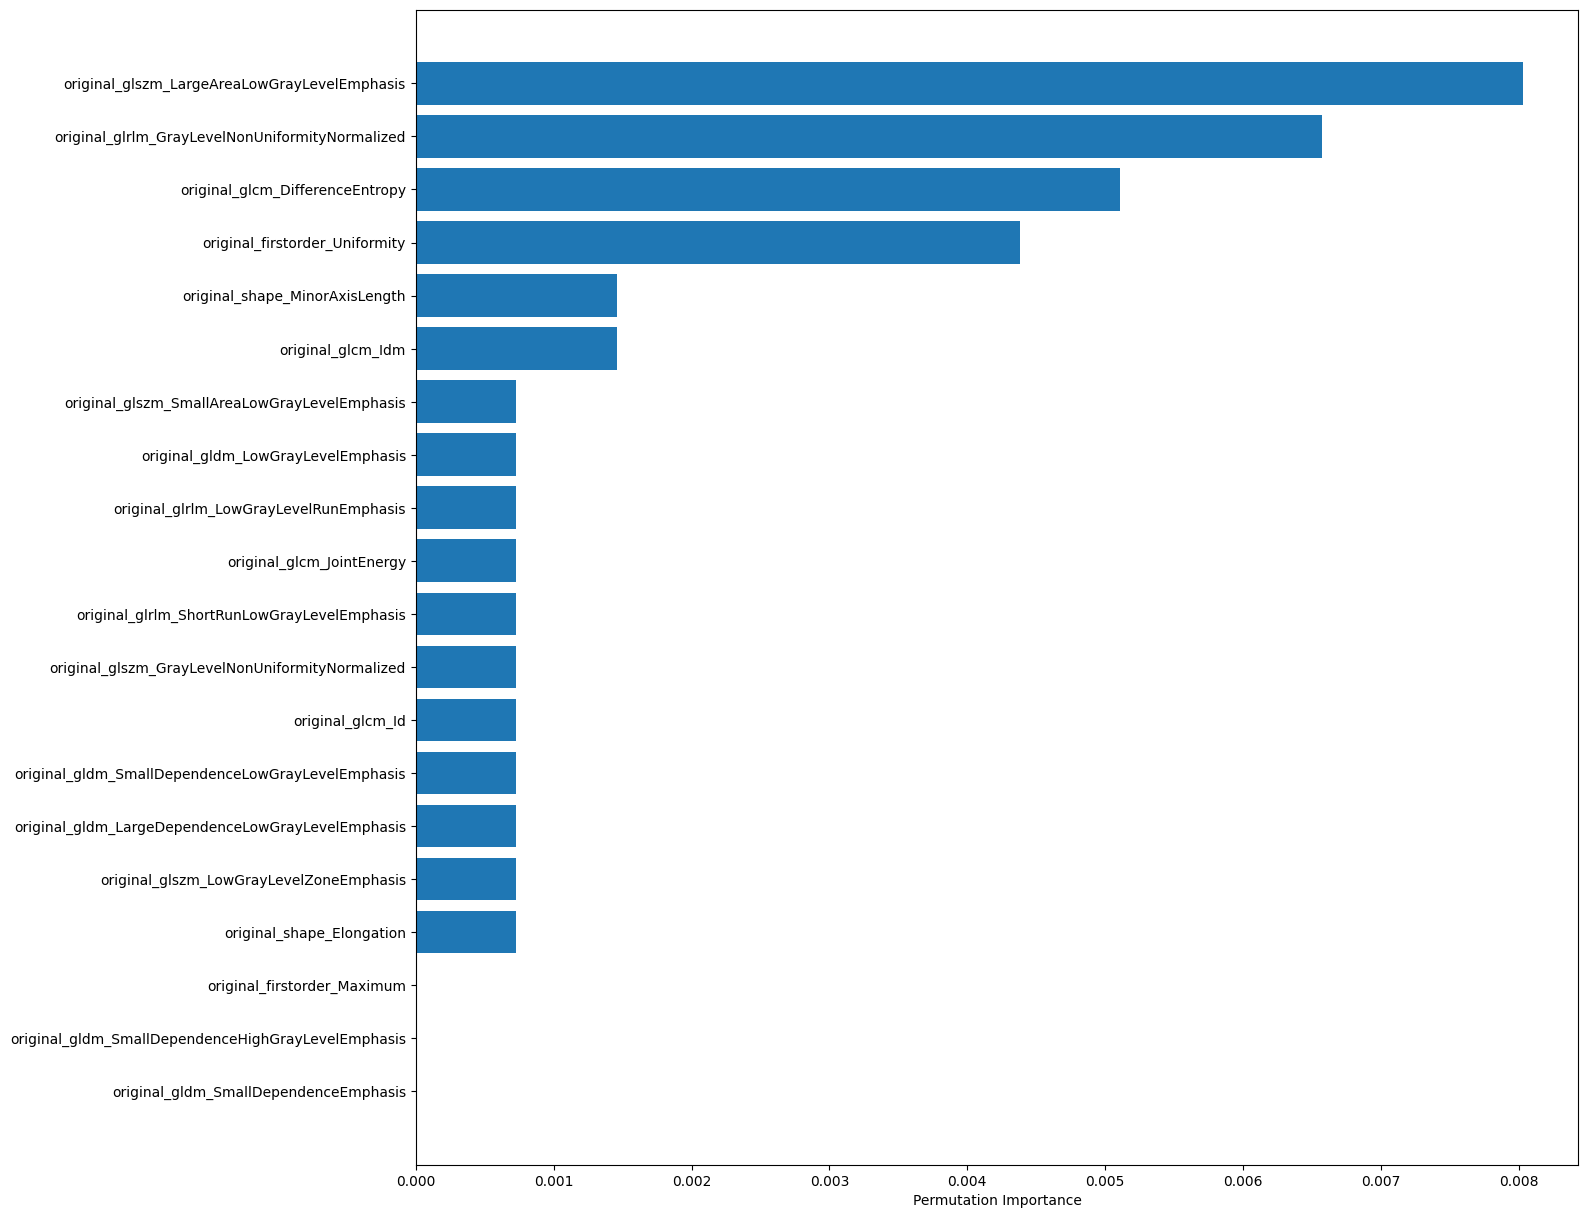

In [ ]:
plt.figure(figsize=(15,15))
plt.barh(features[sorted_idx[-20:]], result.importances_mean[sorted_idx[-20:]])
plt.xlabel("Permutation Importance")

#### Feature Selection with threshold

After analysing the features from the maps above, we will now clean the dataframe with highly correlated variable since they will cause strong assumptions.
Now to do so , we have different techniques , proposed following

In [35]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
# data = load_breast_cancer()
X,y,dataset_all_features  = all_features()
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, random_state=42)

clf = RandomForestClassifier(criterion='gini',n_estimators=100,min_samples_leaf=5, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

(137,)
(137, 100)
Accuracy on test data: 0.63


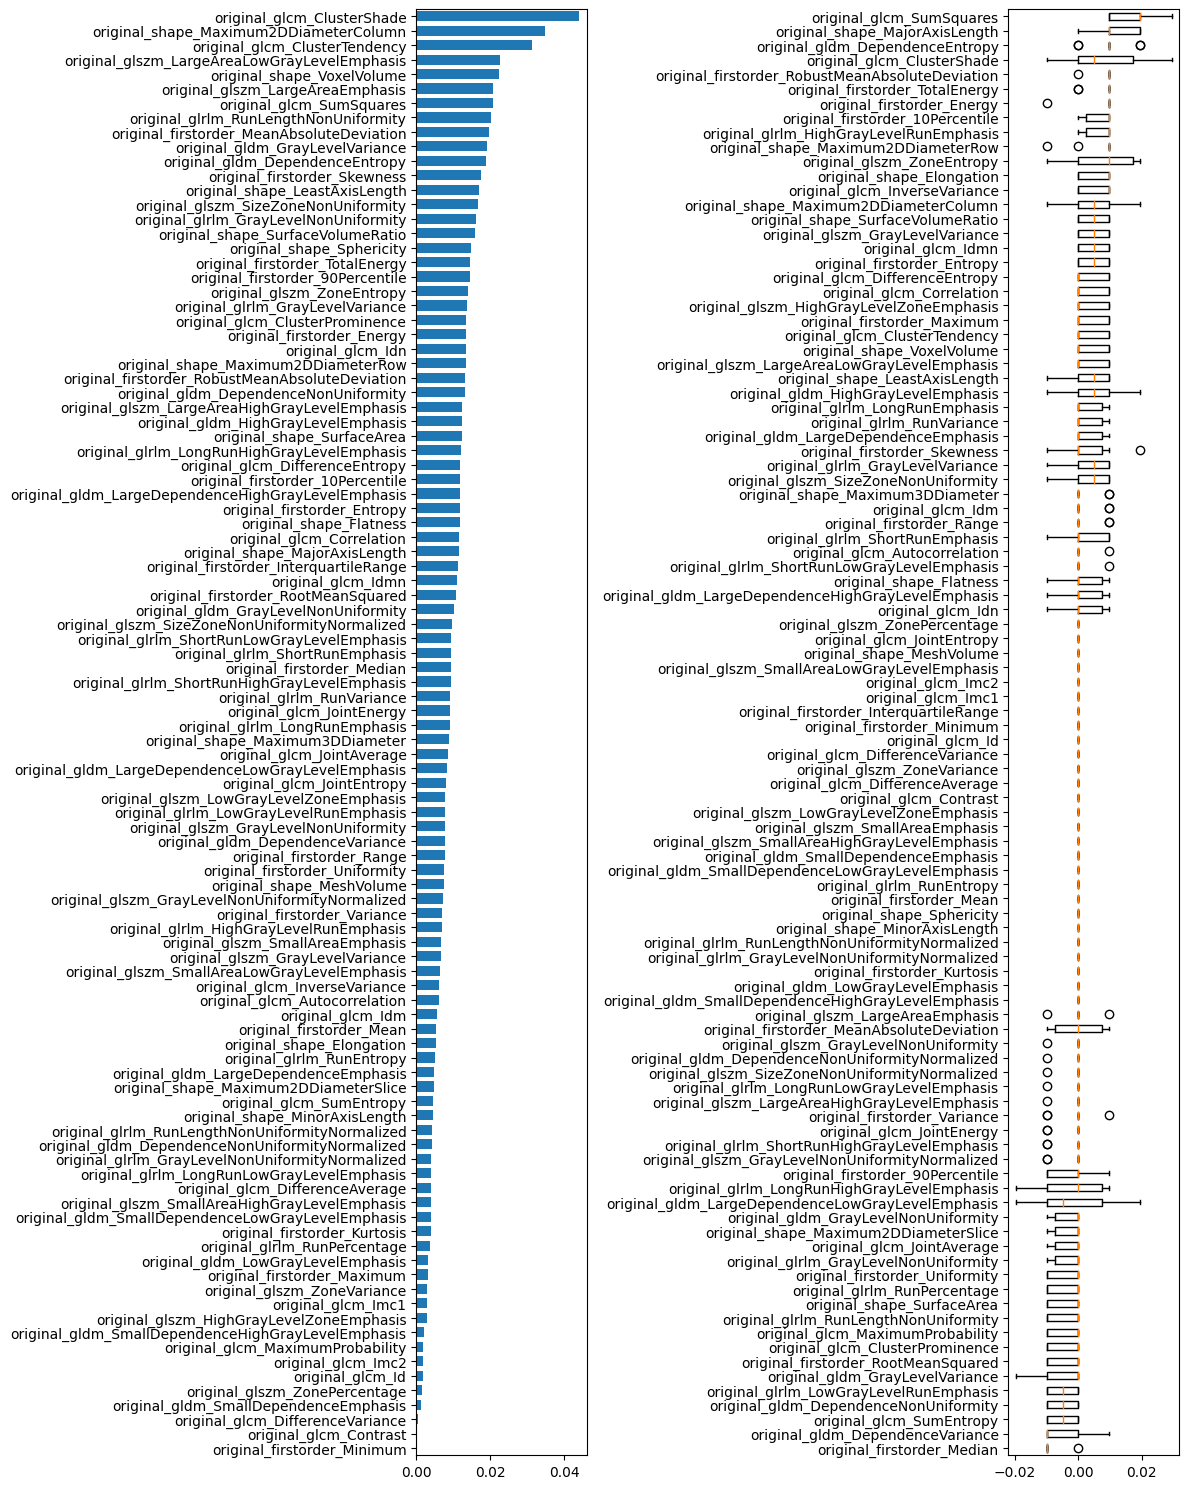

In [36]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 15))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
sorted_feature_names = feature_names.copy()
for i,idx in enumerate(tree_importance_sorted_idx):
      # print(i)
      # print(idx)
      sorted_feature_names[i] = feature_names[idx]
ax1.set_yticklabels(sorted_feature_names)
ax1.set_ylim((0, len(clf.feature_importances_)))
sorted_feature_names = feature_names.copy()
for i,idx in enumerate(perm_sorted_idx):
      sorted_feature_names[i] = feature_names[idx]
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=sorted_feature_names,
)
fig.tight_layout()
plt.show()

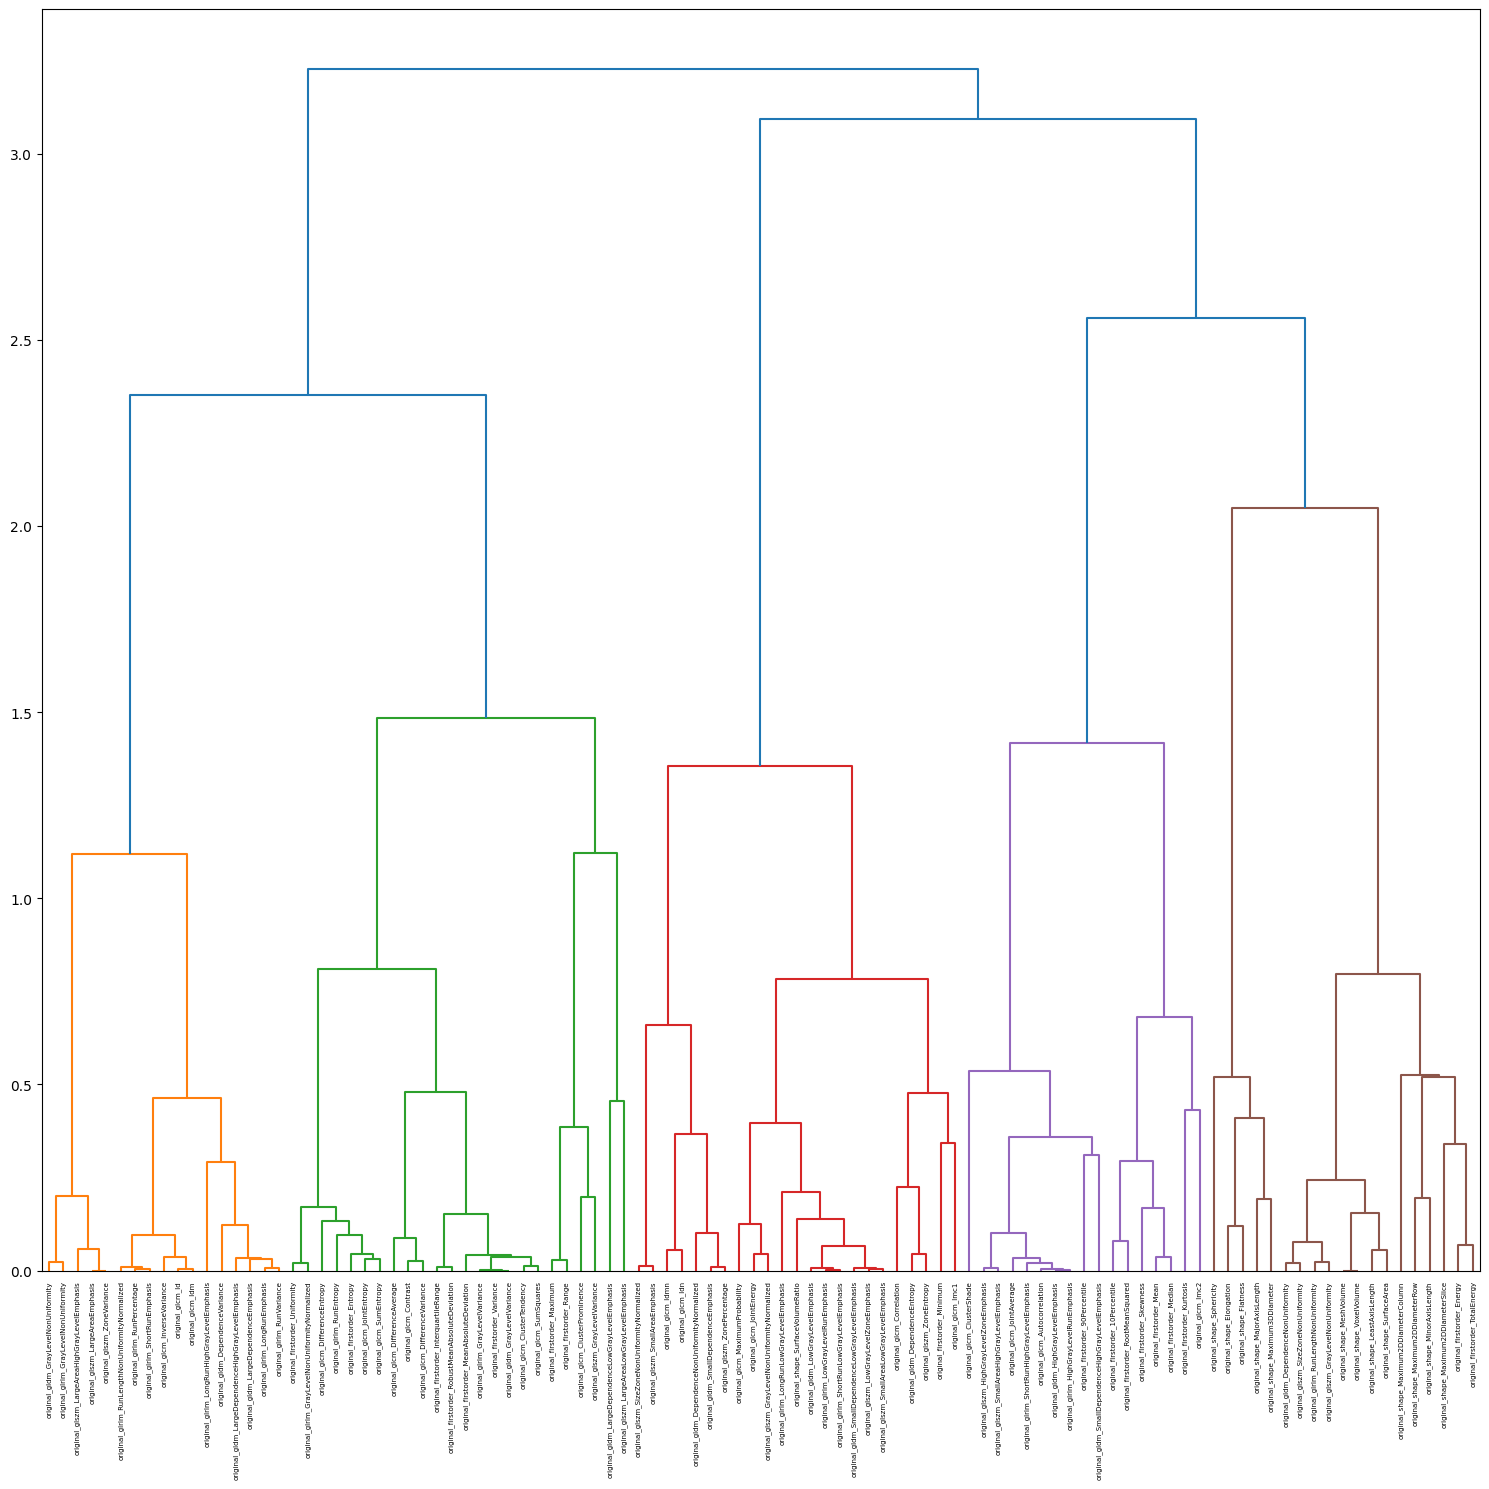

In [37]:

fig, ax1, = plt.subplots(figsize=(15, 15))
d = pandas.DataFrame(data=samples, columns=feature_names)
# corr = spearmanr(samples).correlation
corr = d.corr()

# Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=d.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
fig.tight_layout()
plt.show()

In [38]:
cluster_ids = hierarchy.fcluster(dist_linkage, 0.5, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
print(selected_features)
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(criterion='gini',n_estimators=100,min_samples_leaf=5, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)


[0, 1, 2, 3, 4, 5, 6, 10, 20, 27, 29, 35, 41, 44, 49, 79, 86, 90, 91, 96]
Accuracy on test data with features removed: 0.57


In [39]:
def threshold_permutation_feature_selection(data,threshold):
    data_with_selected_Features1 = data.copy()
    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    columns = list(data_with_selected_Features1.columns)
    print(selected_features)
    res_list = [columns[i] for i in selected_features]
    res_list += ["labels","Patient_id","survival_status"]
    data_with_selected_Features1.drop(columns=[col for col in data_with_selected_Features1 if col not in res_list], inplace=True)
    return data_with_selected_Features1

In [40]:
threshold_permutation_feature_selection(data,0.5)

[0, 1, 2, 3, 4, 5, 6, 10, 20, 27, 29, 35, 41, 44, 49, 79, 86, 90, 91, 96]


original_firstorder_10Percentile  original_firstorder_90Percentile   
0                              -413.4                              41.4  \
1                              -490.2                              35.2   
2                              -696.0                              91.0   
3                              -468.0                             148.0   
4                              -185.0                              51.0   
..                                ...                               ...   
132                            -677.0                             125.4   
133                            -595.0                             112.0   
134                            -753.0                              73.0   
135                            -711.0                             121.7   
136                            -299.0                             113.0   

     original_firstorder_Energy  original_firstorder_Entropy   
0                  1.300704e+08                     4.410179  \
1                  1.509474e+08                     4.437764   
2                  3.482473e+08                     5.154500   
3                  9.123855e+07                     4.813751   
4                  2.327635e+08                     3.444492   
..                          ...                          ...   
132                7.464833e+08                     5.416443   
133                1.868675e+09                     5.324092   
134                7.670512e+08                     5.473738   
135                7.850675e+09                     5.202658   
136                6.557951e+09                     3.992784   

     original_firstorder_InterquartileRange  original_firstorder_Kurtosis   
0                                     266.0                      2.699818  \
1                                     272.0                      3.250647   
2                                     483.5                      2.249295   
3                                     245.5                      3.935420   
4                                      63.0                      8.834677   
..                                      ...                           ...   
132                                   459.5                      2.674535   
133                                   408.0                      2.419308   
134                                   580.0                      1.877307   
135                                   500.0                      2.396296   
136                                   127.0                      6.381430   

     original_firstorder_Maximum  original_firstorder_Minimum   
0                          154.0                       -683.0  \
1                          144.0                       -832.0   
2                          376.0                      -1024.0   
3                          366.0                       -925.0   
4                          391.0                       -778.0   
..                           ...                          ...   
132                        525.0                      -1024.0   
133                        467.0                      -1022.0   
134                        602.0                      -1024.0   
135                       1288.0                      -1024.0   
136                        991.0                       -945.0   

     original_glcm_ClusterShade  original_glcm_Id  ...   
0                  -1671.534680          0.373498  ...  \
1                  -2637.604363          0.338890  ...   
2                  -6713.618430          0.268310  ...   
3                  -4044.809665          0.296079  ...   
4                   -707.758496          0.490608  ...   
..                          ...               ...  ...   
132                -8235.245468          0.232200  ...   
133                -3907.483724          0.239765  ...   
134                -5857.326581          0.221296  ...   
135               -11692.075773          0.275089

##### Random Forest

In [41]:
X_std_list = []
for thres in [0.5,1,1.5]:
        df_drop = threshold_permutation_feature_selection(data,thres)
        print("Selected features are " , df_drop.columns)
        class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['survival_status']))}
        df_drop['survival_status'] = df_drop['survival_status'].map(class_mapping)
        y = LabelEncoder().fit_transform(df_drop['survival_status'].values)
        X = df_drop.iloc[:,0:len(df_drop.columns)-3].values
        print("Y shape" , y.shape)
        print("X shape" , X.shape)
        feat_labels = df_drop.columns[0:len(df_drop.columns)-3]
        stdsc = StandardScaler()
        X_std = stdsc.fit_transform(X)
        X_std_list.append(X_std)

[0, 1, 2, 3, 4, 5, 6, 10, 20, 27, 29, 35, 41, 44, 49, 79, 86, 90, 91, 96]
Selected features are  Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Minimum', 'original_glcm_ClusterShade',
       'original_glcm_Id', 'original_glcm_Idmn', 'original_glcm_JointEnergy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_SizeZoneNonUniformityNormalized',
       'original_shape_Elongation', 'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow', 'original_shape_Sphericity',
       'labels', 'Patient_id', 'survival_status'],
      dtype='object')
Y shape (137,)
X shape (137, 20)
[0, 1, 2, 3, 6, 10, 

In [ ]:
RF_xy_testlist_main_2 = []
RF_xy_trainlist_main_2 = [] 
X_std_list = []
for thres in [0.5,1,1.5]:
        df_drop = threshold_permutation_feature_selection(data,thres)
        print("Selected features are " , df_drop.columns)
        class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['survival_status']))}
        df_drop['survival_status'] = df_drop['survival_status'].map(class_mapping)
        y = LabelEncoder().fit_transform(df_drop['survival_status'].values)
        X = df_drop.iloc[:,0:len(df_drop.columns)-3].values
        print("Y shape" , y.shape)
        print("X shape" , X.shape)
        feat_labels = df_drop.columns[0:len(df_drop.columns)-3]
        stdsc = StandardScaler()
        X_std = stdsc.fit_transform(X)
        RF_xy_testlist,RF_xy_trainlist = RF_CV(X_std,y)
        RF_xy_testlist_main_2.append(RF_xy_testlist)
        RF_xy_trainlist_main_2.append(RF_xy_trainlist)
        X_std_list.append(X_std)

[0, 1, 2, 3, 4, 5, 6, 10, 20, 27, 29, 35, 41, 44, 49, 79, 86, 90, 91, 96]
Selected features are  Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Minimum', 'original_glcm_ClusterShade',
       'original_glcm_Id', 'original_glcm_Idmn', 'original_glcm_JointEnergy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_SizeZoneNonUniformityNormalized',
       'original_shape_Elongation', 'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow', 'original_shape_Sphericity',
       'labels', 'Patient_id', 'survival_status'],
      dtype='object')
Y shape (137,)
X shape (137, 20)
0 >acc=0.643, est=0.

The optimal settings that we selected are 


10 >acc=0.857, est=0.631, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}

In [ ]:
'''3 >acc=0.714, est=0.634, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 100}
10 >acc=0.857, est=0.618, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 100}
13 >acc=0.714, est=0.633, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}'''

"3 >acc=0.714, est=0.634, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 100}\n10 >acc=0.857, est=0.618, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 100}\n13 >acc=0.714, est=0.633, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}"

In [42]:
rf_2_1_tprs,rf_2_1_aucs,rf_2_1_mean_fpr,forest = RandomForest_ROC(X_std_list[0], y, criterion='entropy',n_estimators=100,min_samples_leaf=10)

/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: Depr

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and w

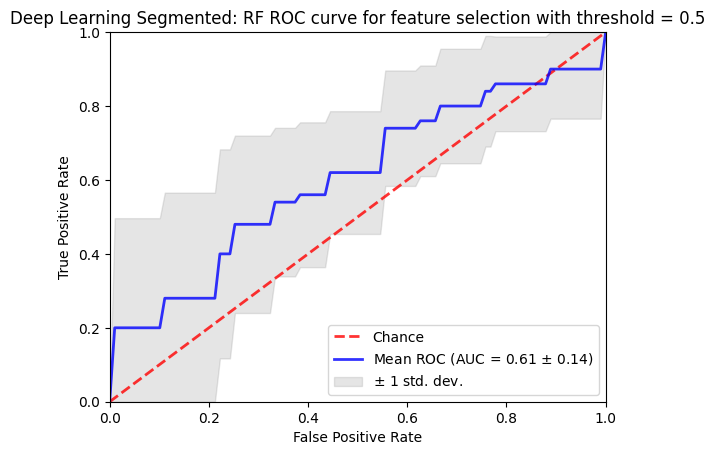

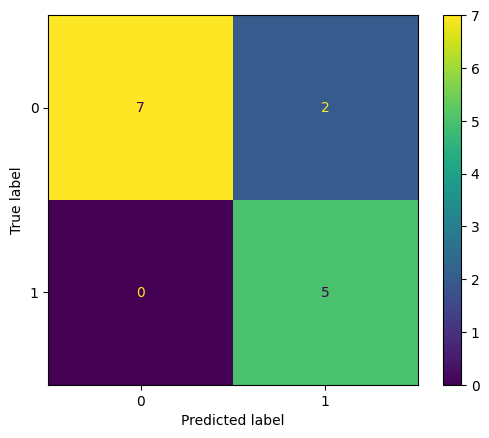

In [ ]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std_list[0], y, criterion='entropy',n_estimators=100,min_samples_leaf=10)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: RF ROC curve for feature selection with threshold = 0.5')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist_main_2[0][10][0], RF_xy_testlist_main_2[0][10][1])

Text(0.5, 0, 'Permutation Importance')

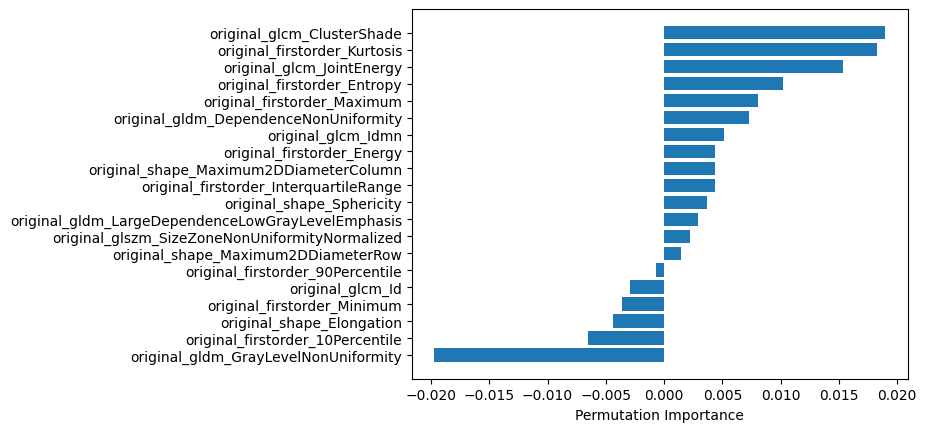

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(forest,X_std_list[0], y, n_repeats=10,random_state=0)
feat  = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Minimum', 'original_glcm_ClusterShade',
       'original_glcm_Id', 'original_glcm_Idmn', 'original_glcm_JointEnergy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_SizeZoneNonUniformityNormalized',
       'original_shape_Elongation', 'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow', 'original_shape_Sphericity']
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
'''2 >acc=0.714, est=0.619, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
10 >acc=0.714, est=0.642, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}'''

"2 >acc=0.714, est=0.619, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}\n10 >acc=0.714, est=0.642, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}"

In [43]:
rf_2_2_tprs,rf_2_2_aucs,rf_2_2_mean_fpr,forest = RandomForest_ROC(X_std_list[1], y, criterion='gini',n_estimators=10,min_samples_leaf=15)

/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: Depr

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and w

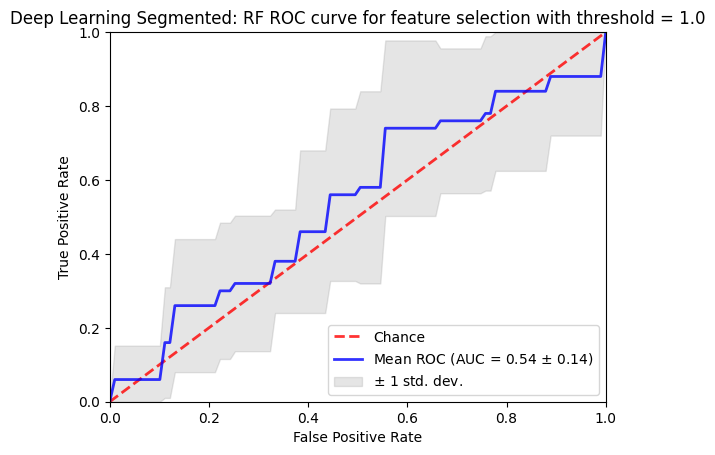

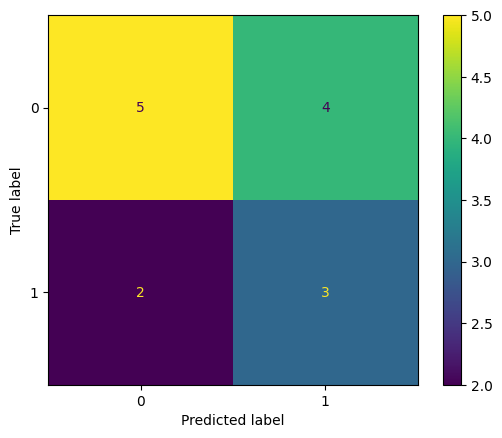

In [ ]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std_list[1], y, criterion='gini',n_estimators=10,min_samples_leaf=15)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: RF ROC curve for feature selection with threshold = 1.0')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist_main_2[1][2][0], RF_xy_testlist_main_2[1][2][1])

Text(0.5, 0, 'Permutation Importance')

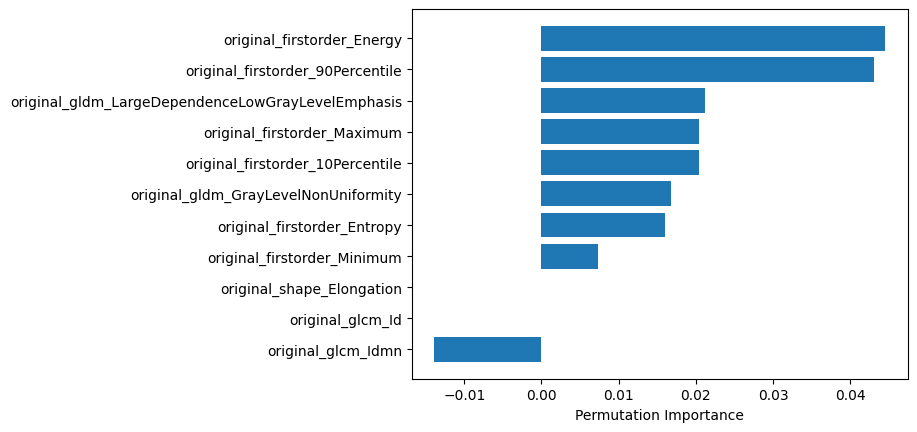

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(forest,X_std_list[1], y, n_repeats=10,random_state=0)
feat = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_Maximum', 'original_firstorder_Minimum',
       'original_glcm_Id', 'original_glcm_Idmn',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_shape_Elongation']
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
'''10 >acc=0.714, est=0.642, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 500}
13 >acc=0.714, est=0.625, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}'''

"10 >acc=0.714, est=0.642, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 500}\n13 >acc=0.714, est=0.625, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}"

In [44]:
rf_2_3_tprs,rf_2_3_aucs,rf_2_3_mean_fpr,forest = RandomForest_ROC(X_std_list[2], y, criterion='gini',n_estimators=10,min_samples_leaf=10)

/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: Depr

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and w

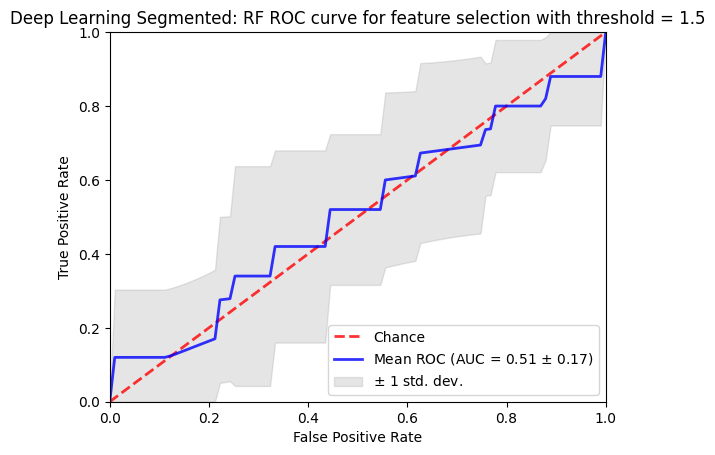

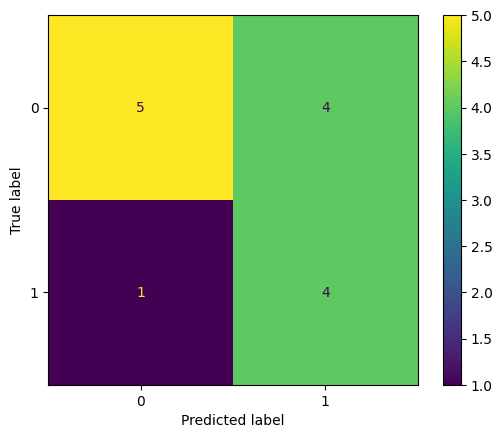

In [ ]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std_list[2], y, criterion='gini',n_estimators=10,min_samples_leaf=10)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: RF ROC curve for feature selection with threshold = 1.5')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist_main_2[2][13][0], RF_xy_testlist_main_2[2][13][1])

Text(0.5, 0, 'Permutation Importance')

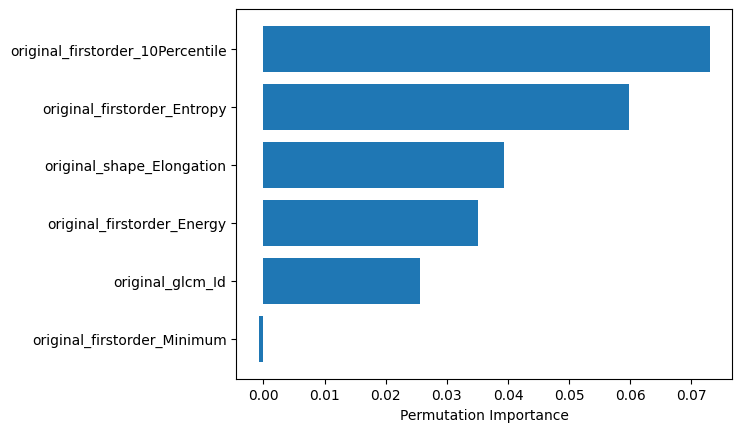

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(forest,X_std_list[2], y, n_repeats=10,random_state=0)
feat = ['original_firstorder_10Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_Minimum',
       'original_glcm_Id', 'original_shape_Elongation']
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

##### SVM

In [85]:
X_std_list = []
for thres in [0.5,1,1.5]:
        df_drop = threshold_permutation_feature_selection(data,thres)
        print("Selected features are " , df_drop.columns)
        class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['survival_status']))}
        class_mapping
        df_drop['survival_status'] = df_drop['survival_status'].map(class_mapping)
        y = LabelEncoder().fit_transform(df_drop['survival_status'].values)
        X = df_drop.iloc[:,0:len(df_drop.columns)-3].values
        print("Y shape" , y.shape)
        print("X shape" , X.shape)
        feat_labels = df_drop.columns[0:len(df_drop.columns)-3]
        stdsc = StandardScaler()
        X_std = stdsc.fit_transform(X)
        X_std_list.append(X_std)

[0, 1, 2, 3, 4, 5, 6, 10, 20, 27, 29, 35, 41, 44, 49, 79, 86, 90, 91, 96]
Selected features are  Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Minimum', 'original_glcm_ClusterShade',
       'original_glcm_Id', 'original_glcm_Idmn', 'original_glcm_JointEnergy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_SizeZoneNonUniformityNormalized',
       'original_shape_Elongation', 'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow', 'original_shape_Sphericity',
       'labels', 'Patient_id', 'survival_status'],
      dtype='object')
Y shape (137,)
X shape (137, 20)
[0, 1, 2, 3, 6, 10, 

In [ ]:
xy_testlist_main_2 = []
xy_trainlist_main_2 = [] 
X_std_list = []
for thres in [0.5,1,1.5]:
        df_drop = threshold_permutation_feature_selection(data,thres)
        print("Selected features are " , df_drop.columns)
        class_mapping = {label: idx for idx, label in enumerate(np.unique(df_drop['survival_status']))}
        class_mapping
        df_drop['survival_status'] = df_drop['survival_status'].map(class_mapping)
        y = LabelEncoder().fit_transform(df_drop['survival_status'].values)
        X = df_drop.iloc[:,0:len(df_drop.columns)-3].values
        print("Y shape" , y.shape)
        print("X shape" , X.shape)
        feat_labels = df_drop.columns[0:len(df_drop.columns)-3]
        stdsc = StandardScaler()
        X_std = stdsc.fit_transform(X)
        xy_testlist,xy_trainlist = SVM_CV(X_std,y)
        xy_testlist_main_2.append(xy_testlist)
        xy_trainlist_main_2.append(xy_trainlist)
        X_std_list.append(X_std)

[0, 1, 2, 3, 4, 5, 6, 10, 20, 27, 29, 35, 41, 44, 49, 79, 86, 90, 91, 96]
Selected features are  Index(['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Minimum', 'original_glcm_ClusterShade',
       'original_glcm_Id', 'original_glcm_Idmn', 'original_glcm_JointEnergy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_SizeZoneNonUniformityNormalized',
       'original_shape_Elongation', 'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow', 'original_shape_Sphericity',
       'labels', 'Patient_id', 'survival_status'],
      dtype='object')
Y shape (137,)
X shape (137, 20)
0 >acc=0.643, est=0.

The optimal settings that we selected are 


12 >acc=0.857, est=0.669, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}

In [ ]:
'''2 >acc=0.857, est=0.651, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
14 >acc=0.714, est=0.642, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}'''

"2 >acc=0.857, est=0.651, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}\n14 >acc=0.714, est=0.642, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}"

In [45]:
svm_2_1_tprs,svm_2_1_aucs,svm_2_1_mean_fpr,svm = SVM_ROC(X_std_list[0],y , C= 1.0, kernel = 'sigmoid' , decision_function_shape = 'ovo')


/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: Depr

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and w

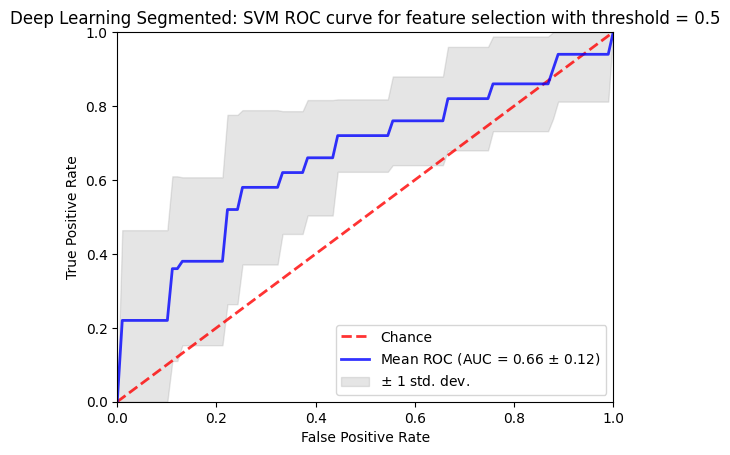

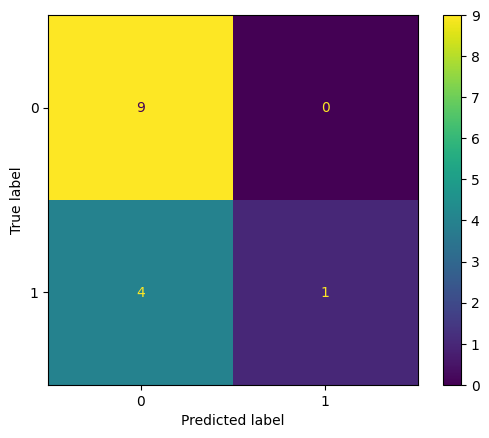

In [ ]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std_list[0],y , C= 1.0, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: SVM ROC curve for feature selection with threshold = 0.5')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist_main_2[0][2][0], xy_testlist_main_2[0][2][1])

Text(0.5, 0, 'Permutation Importance')

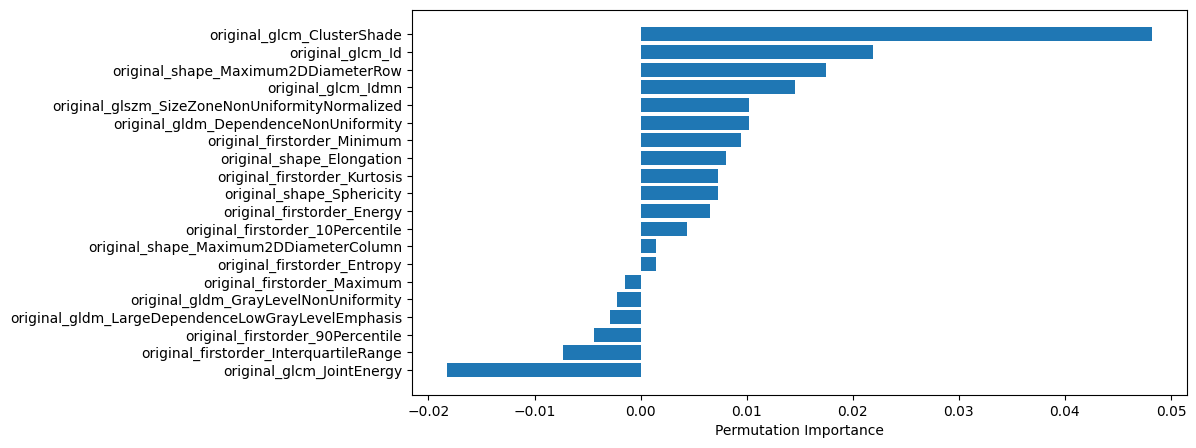

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(svm,X_std_list[0],y, n_repeats=10,random_state=0)
feat  = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_Minimum', 'original_glcm_ClusterShade',
       'original_glcm_Id', 'original_glcm_Idmn', 'original_glcm_JointEnergy',
       'original_gldm_DependenceNonUniformity',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_SizeZoneNonUniformityNormalized',
       'original_shape_Elongation', 'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow', 'original_shape_Sphericity']
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10,5))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
'''8 >acc=0.692, est=0.679, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
19 >acc=0.692, est=0.645, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}'''

"8 >acc=0.692, est=0.679, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}\n19 >acc=0.692, est=0.645, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}"

In [46]:
svm_2_2_tprs,svm_2_2_aucs,svm_2_2_mean_fpr,svm = SVM_ROC(X_std_list[1],y , C= 5, kernel = 'sigmoid' , decision_function_shape = 'ovo')

/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: Depr

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and w

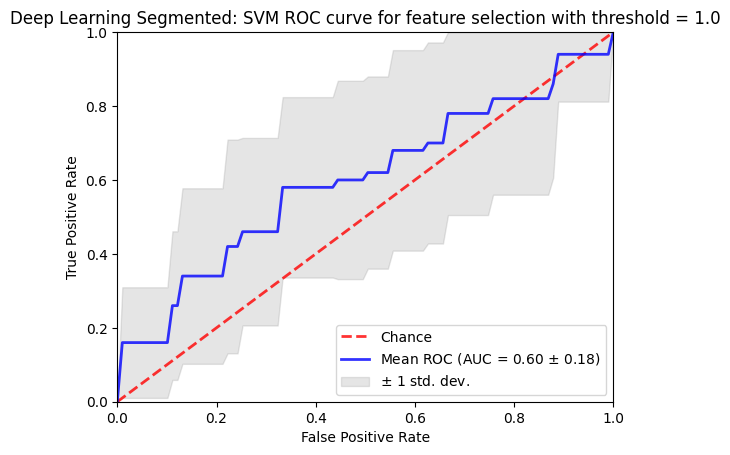

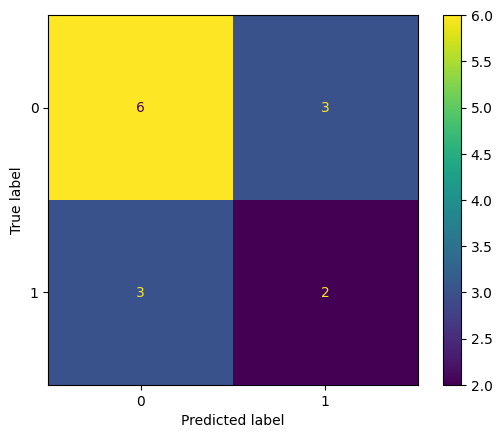

In [ ]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std_list[1],y , C= 5, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: SVM ROC curve for feature selection with threshold = 1.0')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist_main_2[1][5][0], xy_testlist_main_2[1][5][1])

Text(0.5, 0, 'Permutation Importance')

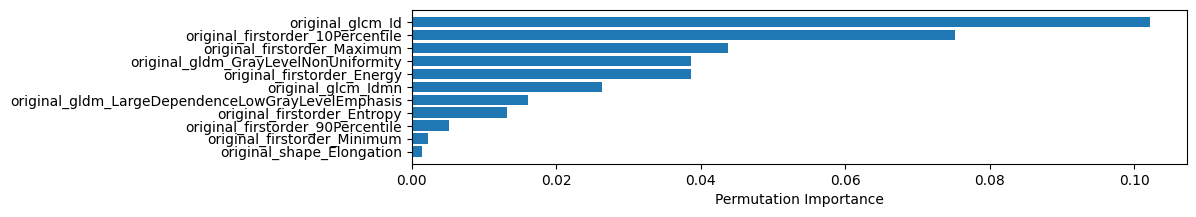

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(svm,X_std_list[1],y, n_repeats=10,random_state=0)
feat  = ['original_firstorder_10Percentile', 'original_firstorder_90Percentile',
       'original_firstorder_Energy', 'original_firstorder_Entropy',
       'original_firstorder_Maximum', 'original_firstorder_Minimum',
       'original_glcm_Id', 'original_glcm_Idmn',
       'original_gldm_GrayLevelNonUniformity',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_shape_Elongation']
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10,2))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
'''0 >acc=0.643, est=0.660, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
1 >acc=0.643, est=0.650, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
2 >acc=0.643, est=0.635, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
3 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
5 >acc=0.643, est=0.658, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
10 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
12 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
13 >acc=0.643, est=0.633, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
14 >acc=0.643, est=0.650, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
15 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}'''

"0 >acc=0.643, est=0.660, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}\n1 >acc=0.643, est=0.650, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}\n2 >acc=0.643, est=0.635, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}\n3 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}\n5 >acc=0.643, est=0.658, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}\n10 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}\n12 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}\n13 >acc=0.643, est=0.633, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}\n14 >acc=0.643, est=0.650, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}\n15 >acc=0.643, est=0.634, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}"

In [47]:
svm_2_3_tprs,svm_2_3_aucs,svm_2_3_mean_fpr,svm = SVM_ROC(X_std_list[2],y , C= 1.0, kernel = 'sigmoid' , decision_function_shape = 'ovo')

/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: Depr

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and w

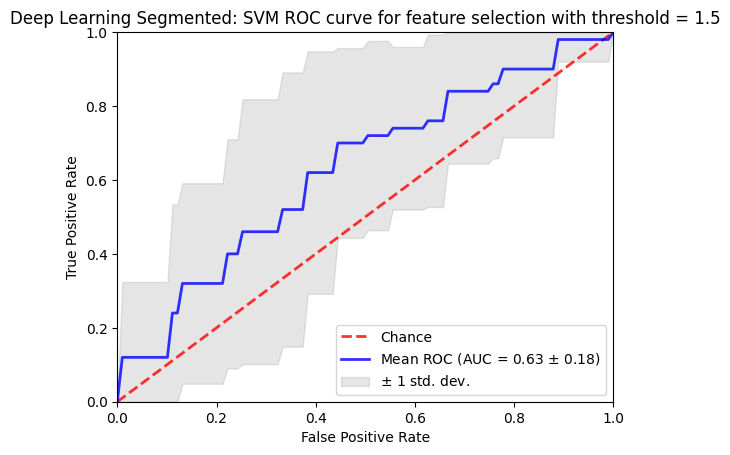

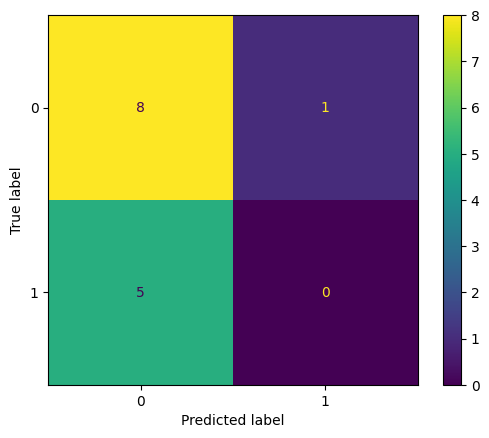

In [ ]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std_list[2],y , C= 1.0, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: SVM ROC curve for feature selection with threshold = 1.5')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist_main_2[2][5][0], xy_testlist_main_2[2][5][1])

Text(0.5, 0, 'Permutation Importance')

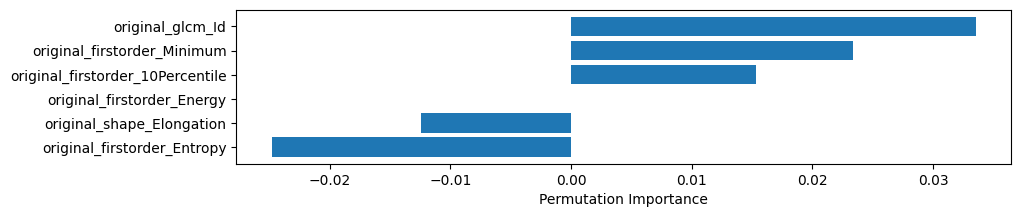

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(svm,X_std_list[2],y, n_repeats=10,random_state=0)
feat  = ['original_firstorder_10Percentile', 'original_firstorder_Energy',
       'original_firstorder_Entropy', 'original_firstorder_Minimum',
       'original_glcm_Id', 'original_shape_Elongation']
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10,2))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

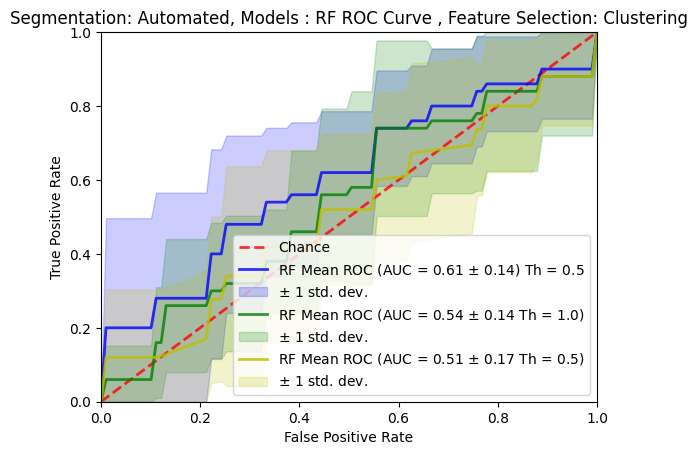

In [70]:
#set up plotting area
plt.figure(0).clf()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
rf_2_1_mean_tpr = np.mean(rf_2_1_tprs, axis=0)
rf_2_1_mean_tpr[-1] = 1.0
rf_2_1_mean_auc = auc(rf_2_1_mean_fpr, rf_2_1_mean_tpr)
rf_2_1_std_auc = np.std(rf_2_1_aucs)
plt.plot(rf_2_1_mean_fpr, rf_2_1_mean_tpr, color='b',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f) Th = 0.5' % (rf_2_1_mean_auc, rf_2_1_std_auc),lw=2, alpha=.8)
rf_2_1_std_tpr = np.std(rf_2_1_tprs, axis=0)
rf_2_1_tprs_upper = np.minimum(rf_2_1_mean_tpr + rf_2_1_std_tpr, 1)
rf_2_1_tprs_lower = np.maximum(rf_2_1_mean_tpr - rf_2_1_std_tpr, 0)
plt.fill_between(rf_2_1_mean_fpr, rf_2_1_tprs_lower, rf_2_1_tprs_upper, color='b', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


rf_2_2_mean_tpr = np.mean(rf_2_2_tprs, axis=0)
rf_2_2_mean_tpr[-1] = 1.0
rf_2_2_mean_auc = auc(rf_2_2_mean_fpr, rf_2_2_mean_tpr)
rf_2_2_std_auc = np.std(rf_2_2_aucs)
plt.plot(rf_2_2_mean_fpr, rf_2_2_mean_tpr, color='g',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 1.0)' % (rf_2_2_mean_auc, rf_2_2_std_auc),lw=2, alpha=.8)
rf_2_2_std_tpr = np.std(rf_2_2_tprs, axis=0)
rf_2_2_tprs_upper = np.minimum(rf_2_2_mean_tpr + rf_2_2_std_tpr, 1)
rf_2_2_tprs_lower = np.maximum(rf_2_2_mean_tpr - rf_2_2_std_tpr, 0)
plt.fill_between(rf_2_2_mean_fpr, rf_2_2_tprs_lower, rf_2_2_tprs_upper, color='g', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


rf_2_3_mean_tpr = np.mean(rf_2_3_tprs, axis=0)
rf_2_3_mean_tpr[-1] = 1.0
rf_2_3_mean_auc = auc(rf_2_3_mean_fpr, rf_2_3_mean_tpr)
rf_2_3_std_auc = np.std(rf_2_3_aucs)
plt.plot(rf_2_3_mean_fpr, rf_2_3_mean_tpr, color='y',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 0.5)' % (rf_2_3_mean_auc, rf_2_3_std_auc),lw=2, alpha=.8)
rf_2_3_std_tpr = np.std(rf_2_3_tprs, axis=0)
rf_2_3_tprs_upper = np.minimum(rf_2_3_mean_tpr + rf_2_3_std_tpr, 1)
rf_2_3_tprs_lower = np.maximum(rf_2_3_mean_tpr - rf_2_3_std_tpr, 0)
plt.fill_between(rf_2_3_mean_fpr, rf_2_3_tprs_lower, rf_2_3_tprs_upper, color='y', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Segmentation: Automated, Models : RF ROC Curve , Feature Selection: Clustering')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
plt.show()

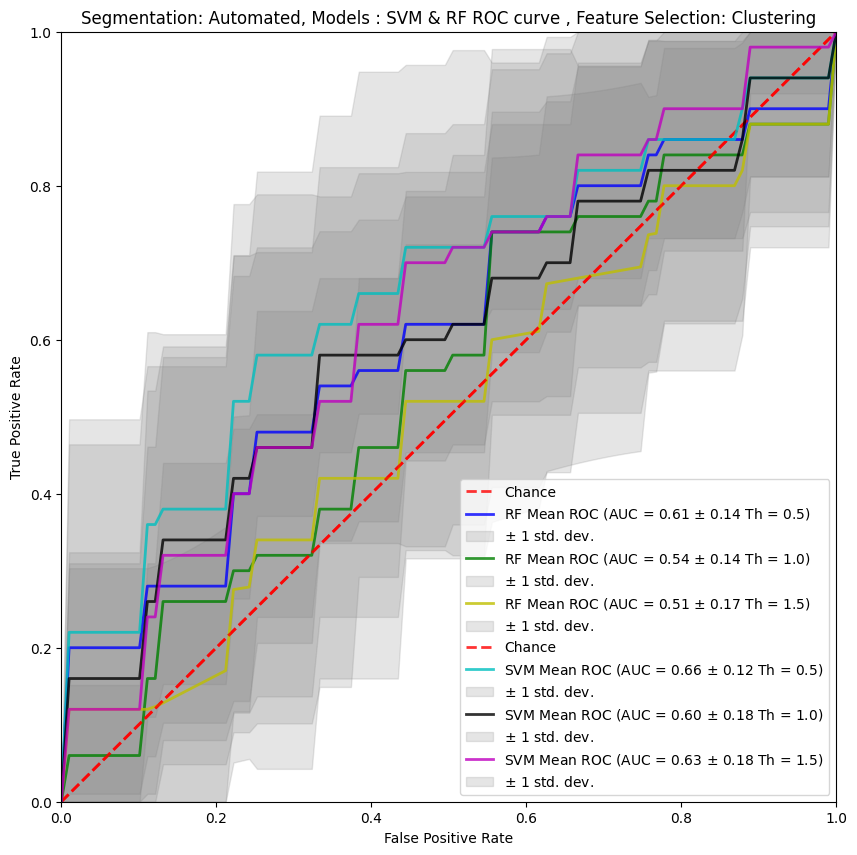

In [50]:
#set up plotting area
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
rf_2_1_mean_tpr = np.mean(rf_2_1_tprs, axis=0)
rf_2_1_mean_tpr[-1] = 1.0
rf_2_1_mean_auc = auc(rf_2_1_mean_fpr, rf_2_1_mean_tpr)
rf_2_1_std_auc = np.std(rf_2_1_aucs)
plt.plot(rf_2_1_mean_fpr, rf_2_1_mean_tpr, color='b',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 0.5)' % (rf_2_1_mean_auc, rf_2_1_std_auc),lw=2, alpha=.8)
rf_2_1_std_tpr = np.std(rf_2_1_tprs, axis=0)
rf_2_1_tprs_upper = np.minimum(rf_2_1_mean_tpr + rf_2_1_std_tpr, 1)
rf_2_1_tprs_lower = np.maximum(rf_2_1_mean_tpr - rf_2_1_std_tpr, 0)
plt.fill_between(rf_2_1_mean_fpr, rf_2_1_tprs_lower, rf_2_1_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


rf_2_2_mean_tpr = np.mean(rf_2_2_tprs, axis=0)
rf_2_2_mean_tpr[-1] = 1.0
rf_2_2_mean_auc = auc(rf_2_2_mean_fpr, rf_2_2_mean_tpr)
rf_2_2_std_auc = np.std(rf_2_2_aucs)
plt.plot(rf_2_2_mean_fpr, rf_2_2_mean_tpr, color='g',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 1.0)' % (rf_2_2_mean_auc, rf_2_2_std_auc),lw=2, alpha=.8)
rf_2_2_std_tpr = np.std(rf_2_2_tprs, axis=0)
rf_2_2_tprs_upper = np.minimum(rf_2_2_mean_tpr + rf_2_2_std_tpr, 1)
rf_2_2_tprs_lower = np.maximum(rf_2_2_mean_tpr - rf_2_2_std_tpr, 0)
plt.fill_between(rf_2_2_mean_fpr, rf_2_2_tprs_lower, rf_2_2_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


rf_2_3_mean_tpr = np.mean(rf_2_3_tprs, axis=0)
rf_2_3_mean_tpr[-1] = 1.0
rf_2_3_mean_auc = auc(rf_2_3_mean_fpr, rf_2_3_mean_tpr)
rf_2_3_std_auc = np.std(rf_2_3_aucs)
plt.plot(rf_2_3_mean_fpr, rf_2_3_mean_tpr, color='y',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 1.5)' % (rf_2_3_mean_auc, rf_2_3_std_auc),lw=2, alpha=.8)
rf_2_3_std_tpr = np.std(rf_2_3_tprs, axis=0)
rf_2_3_tprs_upper = np.minimum(rf_2_3_mean_tpr + rf_2_3_std_tpr, 1)
rf_2_3_tprs_lower = np.maximum(rf_2_3_mean_tpr - rf_2_3_std_tpr, 0)
plt.fill_between(rf_2_3_mean_fpr, rf_2_3_tprs_lower, rf_2_3_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
svm_2_1_mean_tpr = np.mean(svm_2_1_tprs, axis=0)
svm_2_1_mean_tpr[-1] = 1.0
svm_2_1_mean_auc = auc(svm_2_1_mean_fpr, svm_2_1_mean_tpr)
svm_2_1_std_auc = np.std(svm_2_1_aucs)
plt.plot(svm_2_1_mean_fpr, svm_2_1_mean_tpr, color='c',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 0.5)' % (svm_2_1_mean_auc, svm_2_1_std_auc),lw=2, alpha=.8)
svm_2_1_std_tpr = np.std(svm_2_1_tprs, axis=0)
svm_2_1_tprs_upper = np.minimum(svm_2_1_mean_tpr + svm_2_1_std_tpr, 1)
svm_2_1_tprs_lower = np.maximum(svm_2_1_mean_tpr - svm_2_1_std_tpr, 0)
plt.fill_between(svm_2_1_mean_fpr, svm_2_1_tprs_lower, svm_2_1_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


svm_2_2_mean_tpr = np.mean(svm_2_2_tprs, axis=0)
svm_2_2_mean_tpr[-1] = 1.0
svm_2_2_mean_auc = auc(svm_2_2_mean_fpr, svm_2_2_mean_tpr)
svm_2_2_std_auc = np.std(svm_2_2_aucs)
plt.plot(svm_2_2_mean_fpr, svm_2_2_mean_tpr, color='k',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 1.0)' % (svm_2_2_mean_auc, svm_2_2_std_auc),lw=2, alpha=.8)
svm_2_2_std_tpr = np.std(svm_2_2_tprs, axis=0)
svm_2_2_tprs_upper = np.minimum(svm_2_2_mean_tpr + svm_2_2_std_tpr, 1)
svm_2_2_tprs_lower = np.maximum(svm_2_2_mean_tpr - svm_2_2_std_tpr, 0)
plt.fill_between(svm_2_2_mean_fpr, svm_2_2_tprs_lower, svm_2_2_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


svm_2_3_mean_tpr = np.mean(svm_2_3_tprs, axis=0)
svm_2_3_mean_tpr[-1] = 1.0
svm_2_3_mean_auc = auc(svm_2_3_mean_fpr, svm_2_3_mean_tpr)
svm_2_3_std_auc = np.std(svm_2_3_aucs)
plt.plot(svm_2_3_mean_fpr, svm_2_3_mean_tpr, color='m',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 1.5)' % (svm_2_3_mean_auc, svm_2_3_std_auc),lw=2, alpha=.8)
svm_2_3_std_tpr = np.std(svm_2_3_tprs, axis=0)
svm_2_3_tprs_upper = np.minimum(svm_2_3_mean_tpr + svm_2_3_std_tpr, 1)
svm_2_3_tprs_lower = np.maximum(svm_2_3_mean_tpr - svm_2_3_std_tpr, 0)
plt.fill_between(svm_2_3_mean_fpr, svm_2_3_tprs_lower, svm_2_3_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Segmentation: Automated, Models : SVM & RF ROC curve , Feature Selection: Clustering')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )

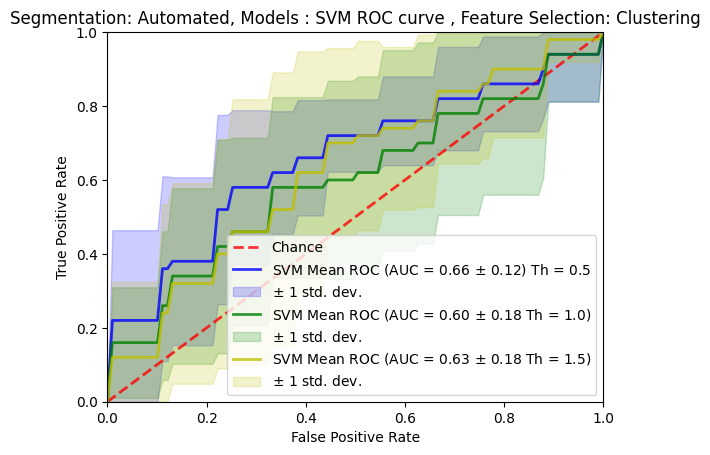

In [52]:
#set up plotting area
plt.figure(0).clf()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
svm_2_1_mean_tpr = np.mean(svm_2_1_tprs, axis=0)
svm_2_1_mean_tpr[-1] = 1.0
svm_2_1_mean_auc = auc(svm_2_1_mean_fpr, svm_2_1_mean_tpr)
svm_2_1_std_auc = np.std(svm_2_1_aucs)
plt.plot(svm_2_1_mean_fpr, svm_2_1_mean_tpr, color='b',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f) Th = 0.5' % (svm_2_1_mean_auc, svm_2_1_std_auc),lw=2, alpha=.8)
svm_2_1_std_tpr = np.std(svm_2_1_tprs, axis=0)
svm_2_1_tprs_upper = np.minimum(svm_2_1_mean_tpr + svm_2_1_std_tpr, 1)
svm_2_1_tprs_lower = np.maximum(svm_2_1_mean_tpr - svm_2_1_std_tpr, 0)
plt.fill_between(svm_2_1_mean_fpr, svm_2_1_tprs_lower, svm_2_1_tprs_upper, color='b', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


svm_2_2_mean_tpr = np.mean(svm_2_2_tprs, axis=0)
svm_2_2_mean_tpr[-1] = 1.0
svm_2_2_mean_auc = auc(svm_2_2_mean_fpr, svm_2_2_mean_tpr)
svm_2_2_std_auc = np.std(svm_2_2_aucs)
plt.plot(svm_2_2_mean_fpr, svm_2_2_mean_tpr, color='g',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 1.0)' % (svm_2_2_mean_auc, svm_2_2_std_auc),lw=2, alpha=.8)
svm_2_2_std_tpr = np.std(svm_2_2_tprs, axis=0)
svm_2_2_tprs_upper = np.minimum(svm_2_2_mean_tpr + svm_2_2_std_tpr, 1)
svm_2_2_tprs_lower = np.maximum(svm_2_2_mean_tpr - svm_2_2_std_tpr, 0)
plt.fill_between(svm_2_2_mean_fpr, svm_2_2_tprs_lower, svm_2_2_tprs_upper, color='g', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


svm_2_3_mean_tpr = np.mean(svm_2_3_tprs, axis=0)
svm_2_3_mean_tpr[-1] = 1.0
svm_2_3_mean_auc = auc(svm_2_3_mean_fpr, svm_2_3_mean_tpr)
svm_2_3_std_auc = np.std(svm_2_3_aucs)
plt.plot(svm_2_3_mean_fpr, svm_2_3_mean_tpr, color='y',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f Th = 1.5)' % (svm_2_3_mean_auc, svm_2_3_std_auc),lw=2, alpha=.8)
svm_2_3_std_tpr = np.std(svm_2_3_tprs, axis=0)
svm_2_3_tprs_upper = np.minimum(svm_2_3_mean_tpr + svm_2_3_std_tpr, 1)
svm_2_3_tprs_lower = np.maximum(svm_2_3_mean_tpr - svm_2_3_std_tpr, 0)
plt.fill_between(svm_2_3_mean_fpr, svm_2_3_tprs_lower, svm_2_3_tprs_upper, color='y', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Segmentation: Automated, Models : SVM ROC curve , Feature Selection: Clustering')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
plt.show()

#### Feature selection with LASSO

In [34]:
def lasso(data):
    X = data.iloc[:,0:len(data.columns)-3]
    y = data['labels'].values
    scaler = StandardScaler()
    scaler.fit(X)
    sel_ = SelectFromModel(
        LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))
    sel_.fit(scaler.transform(X), y)
    removed_feats = X.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    lasso_data = X.drop(columns=removed_feats, axis = 1)
    return lasso_data , y

In [53]:
s = lasso(data)
s[0]

original_firstorder_InterquartileRange  original_firstorder_Minimum   
0                                     266.0                       -683.0  \
1                                     272.0                       -832.0   
2                                     483.5                      -1024.0   
3                                     245.5                       -925.0   
4                                      63.0                       -778.0   
..                                      ...                          ...   
132                                   459.5                      -1024.0   
133                                   408.0                      -1022.0   
134                                   580.0                      -1024.0   
135                                   500.0                      -1024.0   
136                                   127.0                       -945.0   

     original_firstorder_Range  original_glcm_ClusterProminence   
0                        837.0                     58975.259659  \
1                        976.0                     99576.321613   
2                       1400.0                    390469.709822   
3                       1291.0                    189471.470539   
4                       1169.0                     19988.869591   
..                         ...                              ...   
132                     1549.0                    601993.897328   
133                     1489.0                    286791.124250   
134                     1626.0                    543745.355512   
135                     2312.0                    728495.820267   
136                     1936.0                    258596.486589   

     original_glcm_ClusterShade  original_glcm_Contrast  original_glcm_Imc2   
0                  -1671.534680               36.500480            0.772501  \
1                  -2637.604363               60.907873            0.749541   
2                  -6713.618430              138.858625            0.849661   
3                  -4044.809665               95.888358            0.858760   
4                   -707.758496               16.022009            0.577664   
..                          ...                     ...                 ...   
132                -8235.245468              132.758260            0.808453   
133                -3907.483724               83.561811            0.737174   
134                -5857.326581              144.270378            0.837184   
135               -11692.075773               91.210644            0.781085   
136                -5488.895616               10.144635            0.915616   

     original_gldm_DependenceVariance   
0                           12.530581  \
1                            6.887693   
2                            4.450459   
3                            3.955433   
4                           15.211968   
..                                ...   
132                          2.044836   
133                          1.740443   
134                          2.011389   
135                          2.787501   
136                         17.260555   

     original_gldm_LargeDependenceHighGrayLevelEmphasis   
0                                         23964.950502   \
1                                         21758.622626    
2                                         19905.046154    
3                                         17965.783355    
4                                         57838.126473    
..                                                 ...    
132                                       10728.547467    
133                                       10187.939066    
134                                        9221.337054    
135                                       16319.327305    
136                                      113527.997705    

     original_gldm_LargeDependenceLowGrayLevelEmphasis   
0                                             0.043640  \
1                   

##### Random Forest

In [54]:
lasso_data,y = lasso(data)
stdsc = StandardScaler()
X_std_lasso = stdsc.fit_transform(lasso_data.iloc[:].values)

In [ ]:
lasso_data,y = lasso(data)
stdsc = StandardScaler()
X_std_lasso = stdsc.fit_transform(lasso_data.iloc[:].values)
RF_xy_testlist_3,RF_xy_trainlist_3 = RF_CV(X_std_lasso,y)

0 >acc=0.643, est=0.635, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 500}
1 >acc=0.500, est=0.642, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
2 >acc=0.714, est=0.618, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
3 >acc=0.714, est=0.618, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
4 >acc=0.571, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 10}
5 >acc=0.500, est=0.659, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 500}
6 >acc=0.643, est=0.658, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 10}
7 >acc=0.615, est=0.669, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 10}
8 >acc=0.538, est=0.589, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 10}
9 >acc=0.538, est=0.637, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}
10 >acc=0.857, est=0.585, cfg={'criterion': '

In [55]:
rf_3_tprs,rf_3_aucs,rf_3_mean_fpr,forest = RandomForest_ROC(X_std_lasso, y , criterion='entropy',n_estimators=100,min_samples_leaf=15)

/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: Depr

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and w

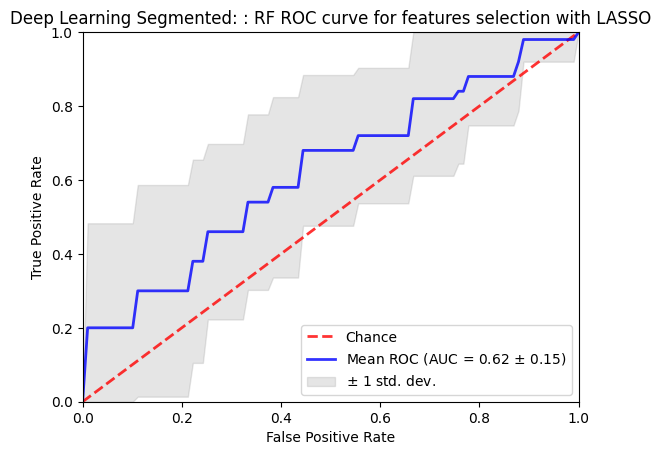

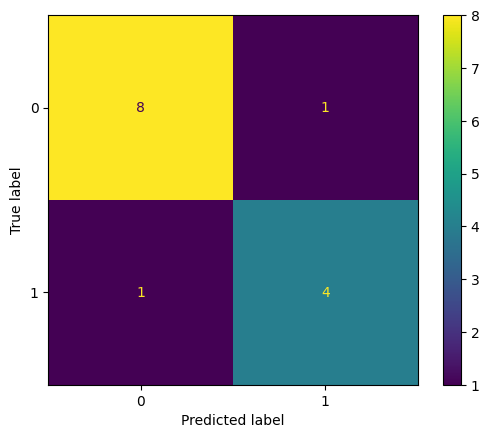

In [ ]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std_lasso, y , criterion='entropy',n_estimators=100,min_samples_leaf=15)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: : RF ROC curve for features selection with LASSO')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist_3[2][0], RF_xy_testlist_3[2][1])

In [ ]:
lasso_data.columns

Index(['original_firstorder_InterquartileRange', 'original_firstorder_Minimum',
       'original_firstorder_Range', 'original_glcm_ClusterProminence',
       'original_glcm_ClusterShade', 'original_glcm_Contrast',
       'original_glcm_Imc2', 'original_gldm_DependenceVariance',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_gldm_LargeDependenceLowGrayLevelEmphasis',
       'original_glszm_GrayLevelNonUniformity',
       'original_glszm_LargeAreaLowGrayLevelEmphasis',
       'original_shape_Flatness', 'original_shape_LeastAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_MinorAxisLength'],
      dtype='object')

Text(0.5, 0, 'Permutation Importance')

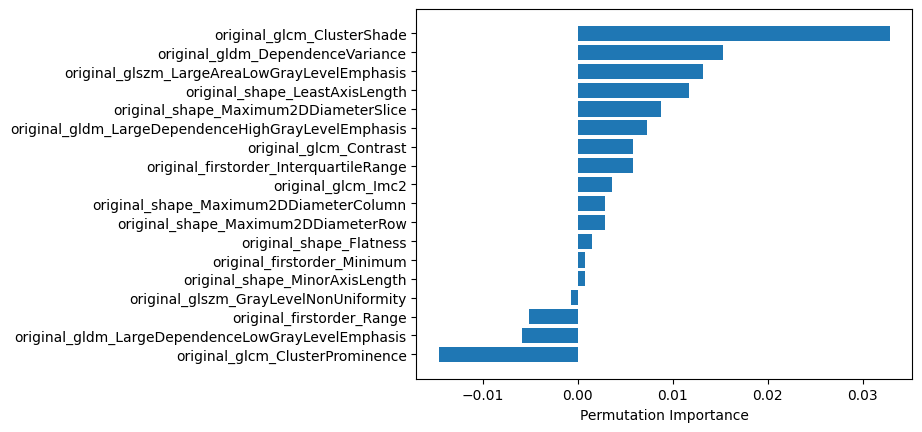

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(forest,X_std_lasso, y, n_repeats=10,random_state=0)
feat  = lasso_data.columns
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

##### SVM

In [56]:
lasso_data,y = lasso(data)
stdsc = StandardScaler()
X_std = stdsc.fit_transform(lasso_data.iloc[:].values)

In [ ]:
lasso_data,y = lasso(data)
stdsc = StandardScaler()
X_std = stdsc.fit_transform(lasso_data.iloc[:].values)
xy_testlist_3,xy_trainlist_3 = SVM_CV(X_std,y)

0 >acc=0.643, est=0.660, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
1 >acc=0.714, est=0.683, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
2 >acc=0.786, est=0.651, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
3 >acc=0.643, est=0.675, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
4 >acc=0.571, est=0.684, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
5 >acc=0.571, est=0.724, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
6 >acc=0.571, est=0.716, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
7 >acc=0.615, est=0.669, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'sigmoid'}
8 >acc=0.615, est=0.686, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
9 >acc=0.538, est=0.686, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
10 >acc=0.714, est=0.635, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 

In [57]:
svm_3_tprs,svm_3_aucs,svm_3_mean_fpr,svm = SVM_ROC(X_std_lasso,y , C= 1.0, kernel = 'sigmoid' , decision_function_shape = 'ovo')

/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: Depr

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and w

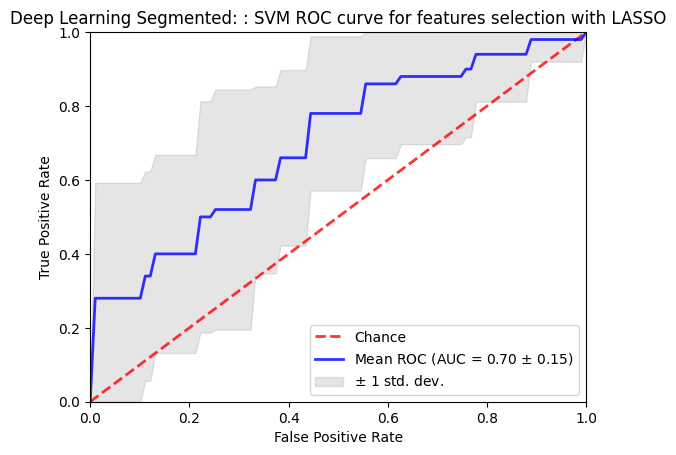

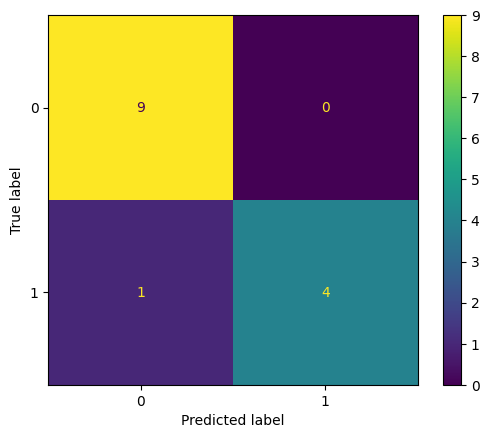

In [ ]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std_lasso,y , C= 1.0, kernel = 'sigmoid' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: : SVM ROC curve for features selection with LASSO')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist_3[10][0], xy_testlist_3[10][1])

Text(0.5, 0, 'Permutation Importance')

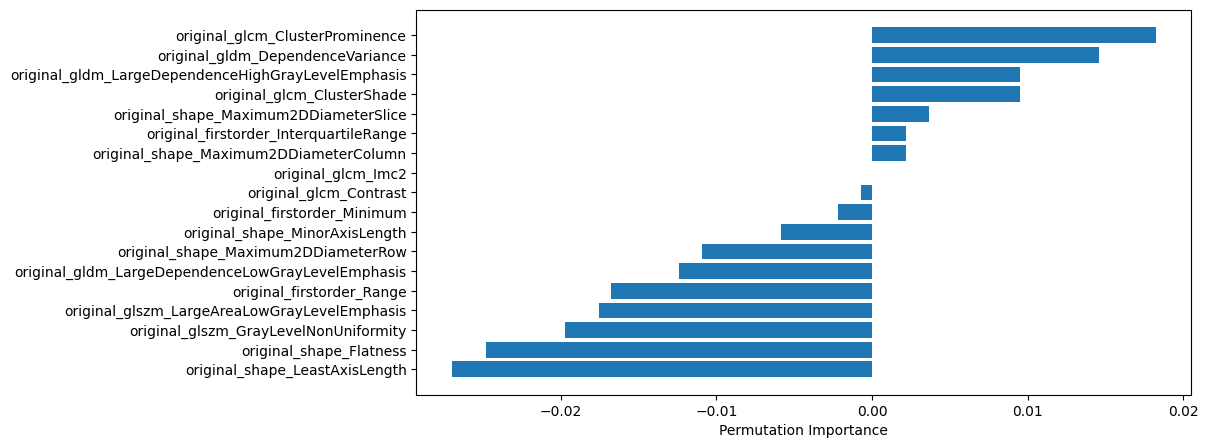

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(svm,X_std_lasso,y, n_repeats=10,random_state=0)
feat  = lasso_data.columns
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10,5))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

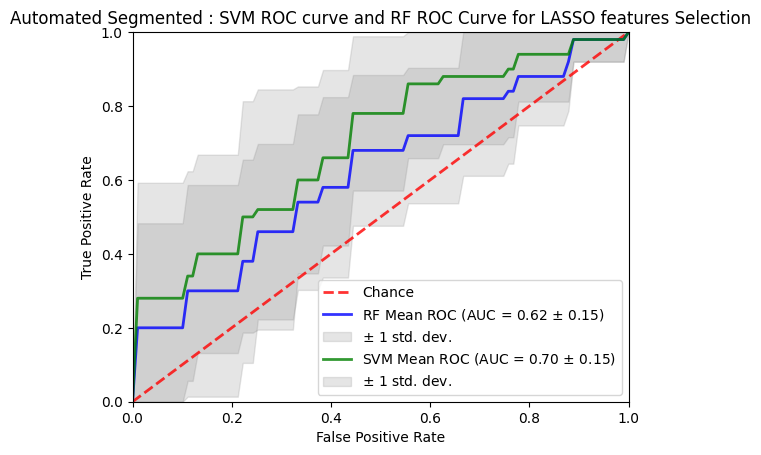

In [58]:
#set up plotting area
plt.figure(0).clf()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
rf_3_mean_tpr = np.mean(rf_3_tprs, axis=0)
rf_3_mean_tpr[-1] = 1.0
rf_3_mean_auc = auc(rf_3_mean_fpr, rf_3_mean_tpr)
rf_3_std_auc = np.std(rf_3_aucs)
plt.plot(rf_3_mean_fpr, rf_3_mean_tpr, color='b',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (rf_3_mean_auc, rf_3_std_auc),lw=2, alpha=.8)
rf_3_std_tpr = np.std(rf_3_tprs, axis=0)
rf_3_tprs_upper = np.minimum(rf_3_mean_tpr + rf_3_std_tpr, 1)
rf_3_tprs_lower = np.maximum(rf_3_mean_tpr - rf_3_std_tpr, 0)
plt.fill_between(rf_3_mean_fpr, rf_3_tprs_lower, rf_3_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

svm_3_mean_tpr = np.mean(svm_3_tprs, axis=0)
svm_3_mean_tpr[-1] = 1.0
svm_3_mean_auc = auc(svm_3_mean_fpr, svm_3_mean_tpr)
svm_3_std_auc = np.std(svm_3_aucs)
plt.plot(svm_3_mean_fpr, svm_3_mean_tpr,color='g',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (svm_3_mean_auc, svm_3_std_auc),lw=2, alpha=.8)
svm_3_std_tpr = np.std(svm_3_tprs, axis=0)
svm_3_tprs_upper = np.minimum(svm_3_mean_tpr + svm_3_std_tpr, 1)
svm_3_tprs_lower = np.maximum(svm_3_mean_tpr - svm_3_std_tpr, 0)
plt.fill_between(svm_3_mean_fpr, svm_3_tprs_lower, svm_3_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Automated Segmented : SVM ROC curve and RF ROC Curve for LASSO features Selection')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
plt.show()

#### Feature Selection with Anova

In [59]:

def anova(data):
    df_anova = data
    class_mapping = {label: idx for idx, label in enumerate(np.unique(df_anova['survival_status']))}
    df_anova['survival_status'] = df_anova['survival_status'].map(class_mapping)
    y_anova = LabelEncoder().fit_transform(df_anova['survival_status'].values)
    X_anova = df_anova.iloc[:,0:len(df_anova.columns)-3].values
    print(y_anova.shape)
    print(X_anova.shape)
    selector = SelectKBest(f_classif, k=20) # k is the number of features to be selected
    X_new = selector.fit_transform(X_anova, y_anova)
    # print('feature importance: ', selector.scores_)
    # print('pvalues: ', selector.pvalues_)
    # len(selector.pvalues_)
    columns = data.columns[:-3]
    feature_scores = list(zip(selector.scores_,columns))
    sorted_feature_scores = sorted(feature_scores,reverse=True)
    num_list = []
    col_list = []
    for i in range(len(columns)):
        num_list.append(sorted_feature_scores[i][0])
        col_list.append(sorted_feature_scores[i][1])
    plt.bar(col_list[0:10],num_list[0:10])
    plt.xticks(rotation=90)
    dfn = 2 # Inter-level degrees of freedom(3-1)
    dfd = 98 # Intra-level degrees of freedom(2345-2)
    fig, ax = plt.subplots(1, 1)

    plt.xlim(-1,26)
    plt.ylim(0,1)
    x = np.linspace(scipy.stats.f.ppf(0.0000000001, dfn, dfd),scipy.stats.f.ppf(0.9999999999, dfn, dfd), 100)
    ax.plot(x, scipy.stats.f.pdf(x, dfn, dfd), 'r-')
    ax.axvline(scipy.stats.f.ppf(0.95, dfn, dfd), ls = "--", color = "navy")
    print('upper 5%:', scipy.stats.f.ppf(0.95, dfn, dfd))
    importance = pd.DataFrame(num_list,index=col_list,columns=['importance'])
    print("Importance of features",importance)
    top_features = importance.nlargest(5, 'importance')
    print("Top features",top_features.index)
    anova_selected_df = df_anova.copy()
    anova_selected_df  = anova_selected_df[anova_selected_df.columns.intersection(top_features.index)]
    print("Anova info",anova_selected_df.info())
    return anova_selected_df,y_anova


In [64]:
import pandas as pd

(137,)
(137, 100)
upper 5%: 3.0892030130201875
Importance of features                                                     importance
original_glcm_ClusterShade                           11.321520
original_glrlm_LongRunHighGrayLevelEmphasis          10.306672
original_gldm_DependenceVariance                      9.247303
original_gldm_LargeDependenceHighGrayLevelEmphasis    9.183634
original_gldm_LargeDependenceEmphasis                 7.252644
...                                                        ...
original_firstorder_Entropy                           0.003787
original_glszm_SmallAreaEmphasis                      0.003511
original_glrlm_GrayLevelNonUniformityNormalized       0.002776
original_shape_Maximum3DDiameter                      0.002557
original_shape_Sphericity                             0.001514

[100 rows x 1 columns]
Top features Index(['original_glcm_ClusterShade',
       'original_glrlm_LongRunHighGrayLevelEmphasis',
       'original_gldm_DependenceVariance',
   

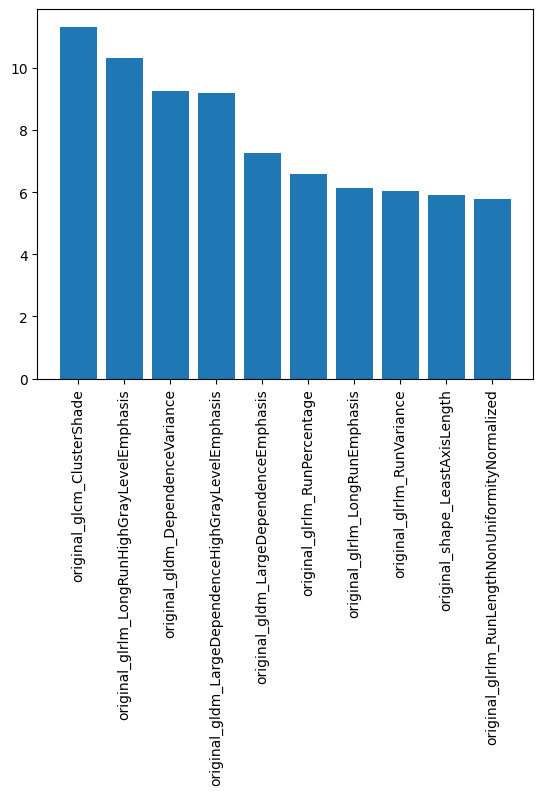

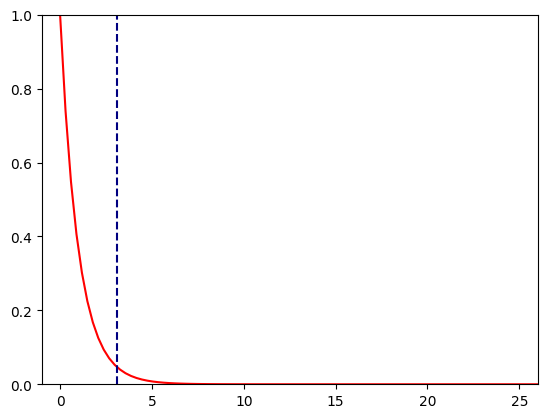

In [65]:
anova_selected_df,y = anova(data)
X_anova = anova_selected_df.values
stdsc = StandardScaler()
X_std_anova = stdsc.fit_transform(X_anova)
print(X_std_anova.shape)

##### Random Forest

In [66]:
rf_4_tprs,rf_4_aucs,rf_4_mean_fpr,forest = RandomForest_ROC(X_std_anova, y , criterion='gini',n_estimators=10,min_samples_leaf=10)

/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/1832163612.py:69: Depr

In [ ]:
RF_xy_testlist_4,RF_xy_trainlist_4 = RF_CV(X_std_anova, y)

0 >acc=0.786, est=0.659, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 500}
1 >acc=0.643, est=0.675, cfg={'criterion': 'entropy', 'min_samples_leaf': 5, 'n_estimators': 10}
2 >acc=0.714, est=0.643, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 100}
3 >acc=0.786, est=0.642, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}
4 >acc=0.357, est=0.725, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 10}
5 >acc=0.500, est=0.683, cfg={'criterion': 'gini', 'min_samples_leaf': 10, 'n_estimators': 100}
6 >acc=0.571, est=0.715, cfg={'criterion': 'entropy', 'min_samples_leaf': 10, 'n_estimators': 100}
7 >acc=0.538, est=0.693, cfg={'criterion': 'gini', 'min_samples_leaf': 15, 'n_estimators': 100}
8 >acc=0.692, est=0.678, cfg={'criterion': 'entropy', 'min_samples_leaf': 15, 'n_estimators': 500}
9 >acc=0.615, est=0.669, cfg={'criterion': 'entropy', 'min_samples_leaf': 15, 'n_estimators': 10}
10 >acc=0.857, est=0.601

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/1832163612.py:69: DeprecationWarning:

scipy.interp is deprecated and w

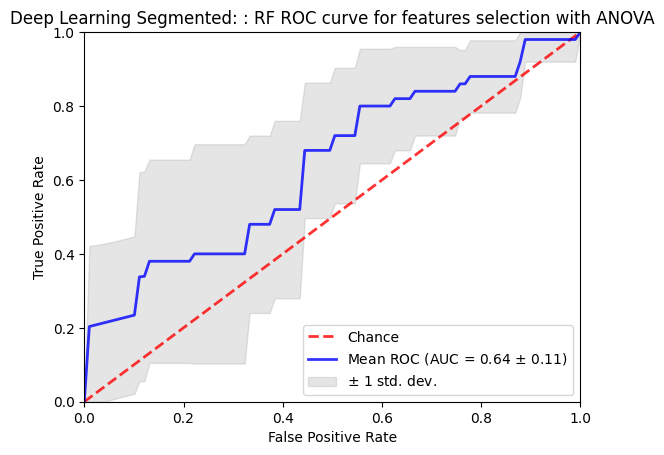

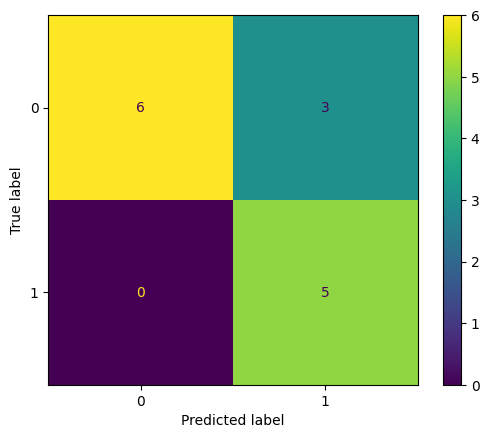

In [ ]:
tprs,aucs,mean_fpr,forest = RandomForest_ROC(X_std_anova, y , criterion='gini',n_estimators=10,min_samples_leaf=10)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: : RF ROC curve for features selection with ANOVA')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(forest, RF_xy_testlist_4[12][0], RF_xy_testlist_4[12][1])

Text(0.5, 0, 'Permutation Importance')

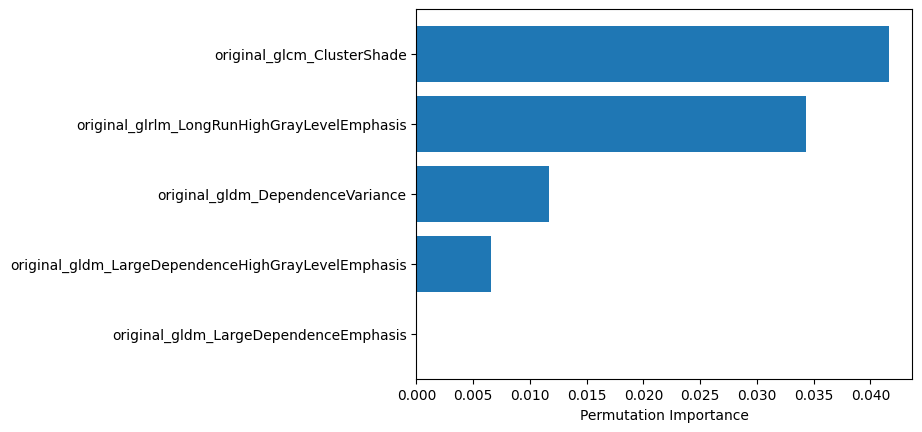

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(forest, X_std_anova, y, n_repeats=10,random_state=0)
feat = ["original_glcm_ClusterShade","original_glrlm_LongRunHighGrayLevelEmphasis","original_gldm_DependenceVariance","original_gldm_LargeDependenceHighGrayLevelEmphasis","original_gldm_LargeDependenceEmphasis"]
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

##### SVM

In [67]:
svm_4_tprs,svm_4_aucs,svm_4_mean_fpr,svm = SVM_ROC(X_std_anova, y , C= 0.1, kernel = 'poly' , decision_function_shape = 'ovo')

/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_4019961/3056392142.py:62: Depr

In [ ]:
xy_testlist_4,xy_trainlist_4 = SVM_CV(X_std_anova, y)

0 >acc=0.643, est=0.660, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
1 >acc=0.643, est=0.683, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
2 >acc=0.643, est=0.651, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
3 >acc=0.714, est=0.635, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
4 >acc=0.429, est=0.677, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
5 >acc=0.571, est=0.650, cfg={'C': 5, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
6 >acc=0.571, est=0.666, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
7 >acc=0.462, est=0.669, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
8 >acc=0.692, est=0.654, cfg={'C': 1.0, 'decision_function_shape': 'ovo', 'kernel': 'rbf'}
9 >acc=0.615, est=0.646, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'poly'}
10 >acc=0.714, est=0.642, cfg={'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'po

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead

/tmp/ipykernel_1706056/3056392142.py:62: DeprecationWarning:

scipy.interp is deprecated and w

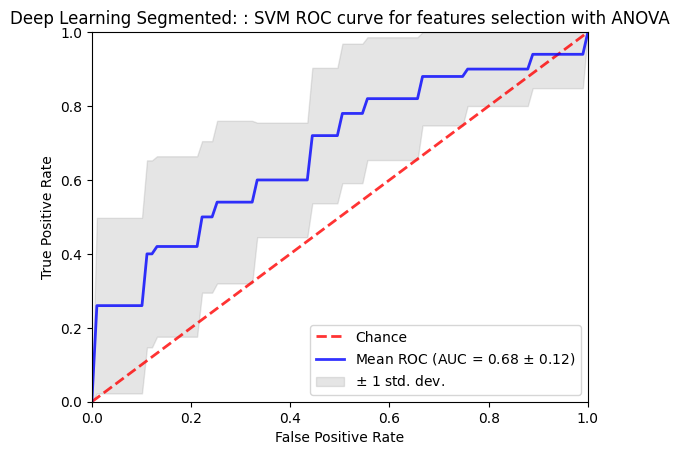

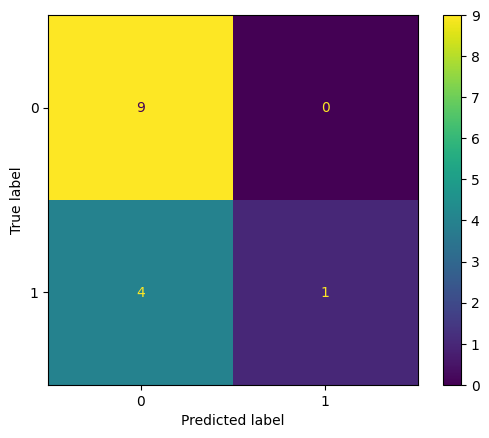

In [ ]:
tprs,aucs,mean_fpr,svm = SVM_ROC(X_std_anova, y , C= 0.1, kernel = 'poly' , decision_function_shape = 'ovo')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Deep Learning Segmented: : SVM ROC curve for features selection with ANOVA')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
        #plt.savefig('RFTC_ROC1.jpg',dpi=1200)
plt.show()
ConfusionMatrixDisplay.from_estimator(svm, xy_testlist_4[10][0], xy_testlist_4[10][1])

Text(0.5, 0, 'Permutation Importance')

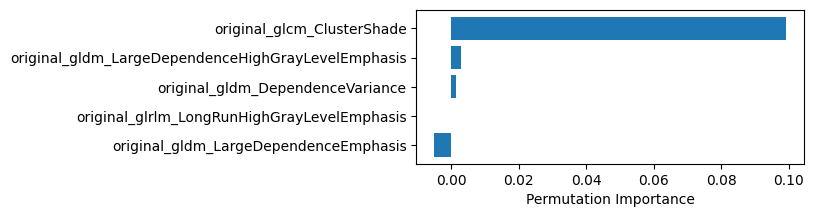

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
result = permutation_importance(svm,X_anova,y, n_repeats=10,random_state=0)
feat = ["original_glcm_ClusterShade","original_glrlm_LongRunHighGrayLevelEmphasis","original_gldm_DependenceVariance","original_gldm_LargeDependenceHighGrayLevelEmphasis","original_gldm_LargeDependenceEmphasis"]
features  =np.array(list(feat)) 
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(5,2))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

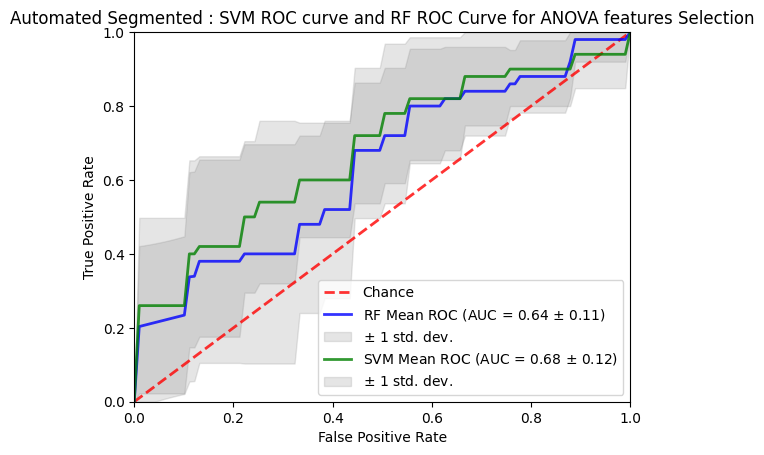

In [69]:
#set up plotting area
plt.figure(0).clf()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
rf_4_mean_tpr = np.mean(rf_4_tprs, axis=0)
rf_4_mean_tpr[-1] = 1.0
rf_4_mean_auc = auc(rf_4_mean_fpr, rf_4_mean_tpr)
rf_4_std_auc = np.std(rf_4_aucs)
plt.plot(rf_4_mean_fpr, rf_4_mean_tpr, color='b',label=r'RF Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (rf_4_mean_auc, rf_4_std_auc),lw=2, alpha=.8)
rf_4_std_tpr = np.std(rf_4_tprs, axis=0)
rf_4_tprs_upper = np.minimum(rf_4_mean_tpr + rf_4_std_tpr, 1)
rf_4_tprs_lower = np.maximum(rf_4_mean_tpr - rf_4_std_tpr, 0)
plt.fill_between(rf_4_mean_fpr, rf_4_tprs_lower, rf_4_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

svm_4_mean_tpr = np.mean(svm_4_tprs, axis=0)
svm_4_mean_tpr[-1] = 1.0
svm_4_mean_auc = auc(svm_4_mean_fpr, svm_4_mean_tpr)
svm_4_std_auc = np.std(svm_4_aucs)
plt.plot(svm_4_mean_fpr, svm_4_mean_tpr,color='g',label=r'SVM Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (svm_4_mean_auc, svm_4_std_auc),lw=2, alpha=.8)
svm_4_std_tpr = np.std(svm_4_tprs, axis=0)
svm_4_tprs_upper = np.minimum(svm_4_mean_tpr + svm_4_std_tpr, 1)
svm_4_tprs_lower = np.maximum(svm_4_mean_tpr - svm_4_std_tpr, 0)
plt.fill_between(svm_4_mean_fpr, svm_4_tprs_lower, svm_4_tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0, 1])
plt.ylim([-0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Automated Segmented : SVM ROC curve and RF ROC Curve for ANOVA features Selection')
plt.legend(loc="lower right" ,
                #fontsize = 'xx-small'
                )
plt.show()